In [1]:
import numpy as np
from numpy import random
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import multivariate_normal
from sklearn import datasets
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

In [2]:
class GMM():
    def __init__(self, k, dim, init_mu=None, init_sigma=None, init_pi=None, colors=None):
        '''
        Define a model with known number of clusters and dimensions.
        input:
            - k: Number of Gaussian clusters
            - dim: Dimension
            - init_mu: initial value of mean of clusters (k, dim)
                       (default) random from uniform[-10, 10]
            - init_sigma: initial value of covariance matrix of clusters (k, dim, dim)
                          (default) Identity matrix for each cluster
            - init_pi: initial value of cluster weights (k,)
                       (default) equal value to all cluster i.e. 1/k
            - colors: Color valu for plotting each cluster (k, 3)
                      (default) random from uniform[0, 1]
        '''
        self.k = k
        self.dim = dim
        if(init_mu is None):
            init_mu = random.rand(k, dim)
        self.mu = init_mu
        if(init_sigma is None):
            init_sigma = np.zeros((k, dim, dim))
            for i in range(k):
                init_sigma[i] = np.eye(dim)
        self.sigma = init_sigma
        if(init_pi is None):
            init_pi = np.ones(self.k)/self.k
        self.pi = init_pi
        if(colors is None):
            colors = random.rand(k, 3)
            for i in range(k):
                colors[i, 2] = i/k
        self.colors = colors

    def init_em(self, X):
        '''
        Initialization for EM algorithm.
        input:
            - X: data (batch_size, dim)
        '''
        self.data = X
        self.num_points = X.shape[0]
        self.z = np.zeros((self.num_points, self.k))

    def e_step(self):
        '''
        E-step of EM algorithm.
        '''
        for i in range(self.k):
            self.z[:, i] = self.pi[i] * multivariate_normal.pdf(self.data, mean=self.mu[i], cov=self.sigma[i], allow_singular=True)
        self.z /= self.z.sum(axis=1, keepdims=True)

    def m_step(self):
        '''
        M-step of EM algorithm.
        '''
        sum_z = self.z.sum(axis=0)
        self.pi = sum_z / self.num_points
        self.mu = np.matmul(self.z.T, self.data)
        self.mu /= sum_z[:, None]
        for i in range(self.k):
            j = np.expand_dims(self.data, axis=1) - self.mu[i]
            s = np.matmul(j.transpose([0, 2, 1]), j)
            self.sigma[i] = np.matmul(s.transpose(1, 2, 0), self.z[:, i] )
            self.sigma[i] /= sum_z[i]

    def log_likelihood(self, X):
        '''
        Compute the log-likelihood of X under current parameters
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of X: Sum_n Sum_k log(pi_k * N( X_n | mu_k, sigma_k ))
        '''
        ll = []
        for d in X:
            tot = 0
            for i in range(self.k):
                tot += self.pi[i] * multivariate_normal.pdf(d, mean=self.mu[i], cov=self.sigma[i], allow_singular=True)
            ll.append(np.log(tot))
        print(self.sigma)
        return np.sum(ll)

    def plot_gaussian(self, mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
        '''
        Utility function to plot one Gaussian from mean and covariance.
        '''
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x = mean[0]
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y = mean[1]
        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)
        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)

    def draw(self, ax, n_std=2.0, facecolor='none', **kwargs):
        '''
        Function to draw the Gaussians.
        Note: Only for two-dimensionl dataset
        '''
        if(self.dim != 2):
            print("Drawing available only for 2D case.")
            return
        for i in range(self.k):
            self.plot_gaussian(self.mu[i], self.sigma[i], ax, n_std=n_std, edgecolor=self.colors[i], **kwargs)

In [3]:
X, y = datasets.load_iris(return_X_y=True)

In [4]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


In [6]:
def gen_data(k=3, dim=2, points_per_cluster=200, lim=[-10, 10]):
    '''
    Generates data from a random mixture of Gaussians in a given range.
    Will also plot the points in case of 2D.
    input:
        - k: Number of Gaussian clusters
        - dim: Dimension of generated points
        - points_per_cluster: Number of points to be generated for each cluster
        - lim: Range of mean values
    output:
        - X: Generated points (points_per_cluster*k, dim)
    '''
    x = []
    mean = random.rand(k, dim)*(lim[1]-lim[0]) + lim[0]
    for i in range(k):
        cov = random.rand(dim, dim+10)
        cov = np.matmul(cov, cov.T)
        _x = np.random.multivariate_normal(mean[i], cov, points_per_cluster)
        x += list(_x)
    x = np.array(x)
    if(dim == 2):
        fig = plt.figure()
        ax = fig.gca()
        ax.scatter(x[:,0], x[:,1], s=3, alpha=0.4)
        ax.autoscale(enable=True) 
    return x

In [7]:
def plot(title):
    '''
    Draw the data points and the fitted mixture model.
    input:
        - title: title of plot and name with which it will be saved.
    '''
    pca = PCA(n_components=2)
    decomposed_X = pca.fit_transform(X)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    ax.scatter(decomposed_X[:, 0], decomposed_X[:, 1], s=3, alpha=0.4)
    ax.scatter(gmm.mu[:, 0], gmm.mu[:, 1], c=gmm.colors)
    gmm.draw(ax, lw=3)
    ax.set_xlim((-22, 22))
    ax.set_ylim((-22, 22))

    plt.title(title)
    # plt.savefig(title.replace(':', '_'))
    plt.show()
    plt.clf()

In [8]:
# Create a Gaussian Mixture Model
gmm = GMM(3, 4)

[[[1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]]

 [[1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]]

 [[1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]]]
Drawing available only for 2D case.


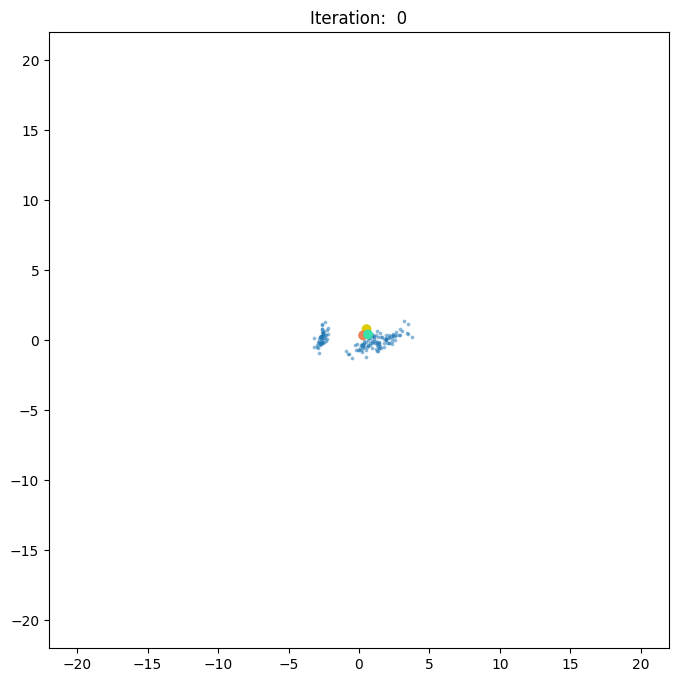

[[[ 0.67112616 -0.0334333   1.21962655  0.49211216]
  [-0.0334333   0.18265416 -0.29831449 -0.10798445]
  [ 1.21962655 -0.29831449  2.94604449  1.2252128 ]
  [ 0.49211216 -0.10798445  1.2252128   0.55434087]]

 [[ 0.59202043 -0.03927582  1.12261739  0.46467325]
  [-0.03927582  0.19376382 -0.33095126 -0.12381864]
  [ 1.12261739 -0.33095126  2.87576748  1.21393866]
  [ 0.46467325 -0.12381864  1.21393866  0.54903581]]

 [[ 0.3630695  -0.01256471  0.64779468  0.26493065]
  [-0.01256471  0.21078564 -0.31158929 -0.12015064]
  [ 0.64779468 -0.31158929  1.81329464  0.73963461]
  [ 0.26493065 -0.12015064  0.73963461  0.31935609]]]
Iteration: 1, log-likelihood: -372.2342
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

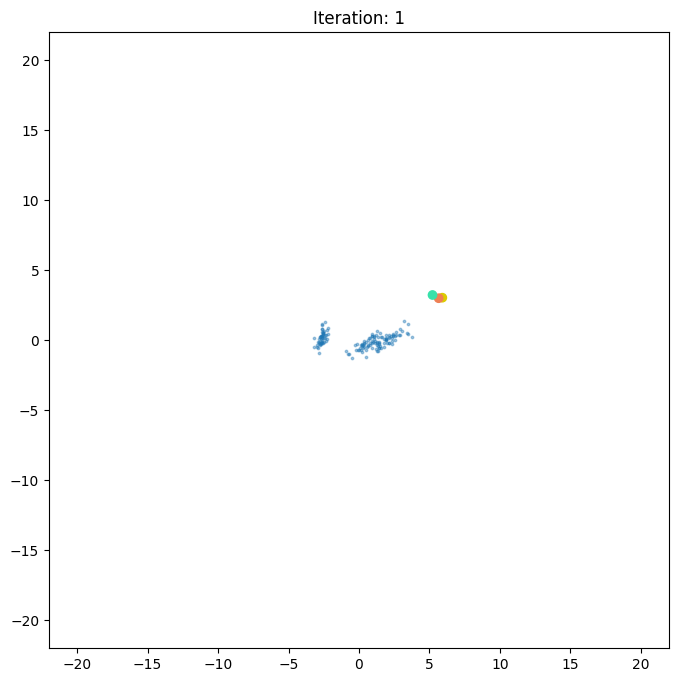

[[[ 0.67305907 -0.02138024  1.19320306  0.47939887]
  [-0.02138024  0.16810006 -0.24932725 -0.08722405]
  [ 1.19320306 -0.24932725  2.80975223  1.16847973]
  [ 0.47939887 -0.08722405  1.16847973  0.53336693]]

 [[ 0.5241282  -0.04303646  1.02315583  0.43033388]
  [-0.04303646  0.19716113 -0.34048685 -0.12785596]
  [ 1.02315583 -0.34048685  2.73147583  1.16232257]
  [ 0.43033388 -0.12785596  1.16232257  0.52469486]]

 [[ 0.20230239  0.02828105  0.28632892  0.11731255]
  [ 0.02828105  0.24248187 -0.28062231 -0.10656114]
  [ 0.28632892 -0.28062231  1.01832515  0.40158821]
  [ 0.11731255 -0.10656114  0.40158821  0.16797246]]]
Iteration: 2, log-likelihood: -356.2068
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

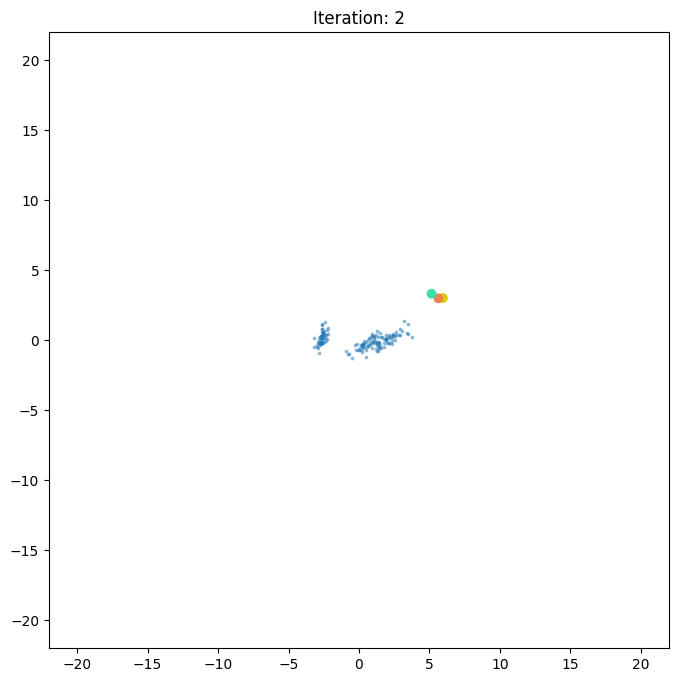

[[[ 0.64084579  0.01136087  1.05796706  0.41970251]
  [ 0.01136087  0.13875091 -0.13216688 -0.03731591]
  [ 1.05796706 -0.13216688  2.3401791   0.97149468]
  [ 0.41970251 -0.03731591  0.97149468  0.45511862]]

 [[ 0.45659553 -0.04789527  0.91318075  0.38587158]
  [-0.04789527  0.18644692 -0.32491922 -0.12061538]
  [ 0.91318075 -0.32491922  2.49969105  1.06395799]
  [ 0.38587158 -0.12061538  1.06395799  0.47745737]]

 [[ 0.13327038  0.07454891  0.08115954  0.03610425]
  [ 0.07454891  0.23476014 -0.18067695 -0.06568317]
  [ 0.08115954 -0.18067695  0.44865983  0.17061122]
  [ 0.03610425 -0.06568317  0.17061122  0.07261848]]]
Iteration: 3, log-likelihood: -326.0307
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

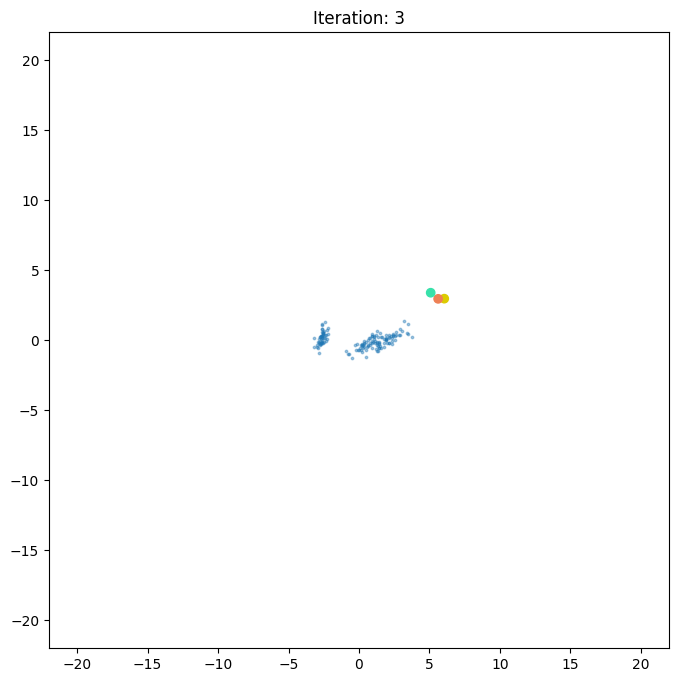

[[[ 0.54945262  0.07078663  0.76386904  0.29405804]
  [ 0.07078663  0.11572514  0.0305015   0.03240121]
  [ 0.76386904  0.0305015   1.47991606  0.61230598]
  [ 0.29405804  0.03240121  0.61230598  0.30982096]]

 [[ 0.3872916  -0.0371292   0.75985084  0.3175278 ]
  [-0.0371292   0.17011899 -0.25763663 -0.08921764]
  [ 0.75985084 -0.25763663  2.04815376  0.86188441]
  [ 0.3175278  -0.08921764  0.86188441  0.38395448]]

 [[ 0.11963154  0.09521589  0.01534438  0.01086341]
  [ 0.09521589  0.17233578 -0.04837823 -0.01373646]
  [ 0.01534438 -0.04837823  0.12041231  0.0416735 ]
  [ 0.01086341 -0.01373646  0.0416735   0.02258734]]]
Iteration: 4, log-likelihood: -268.4334
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

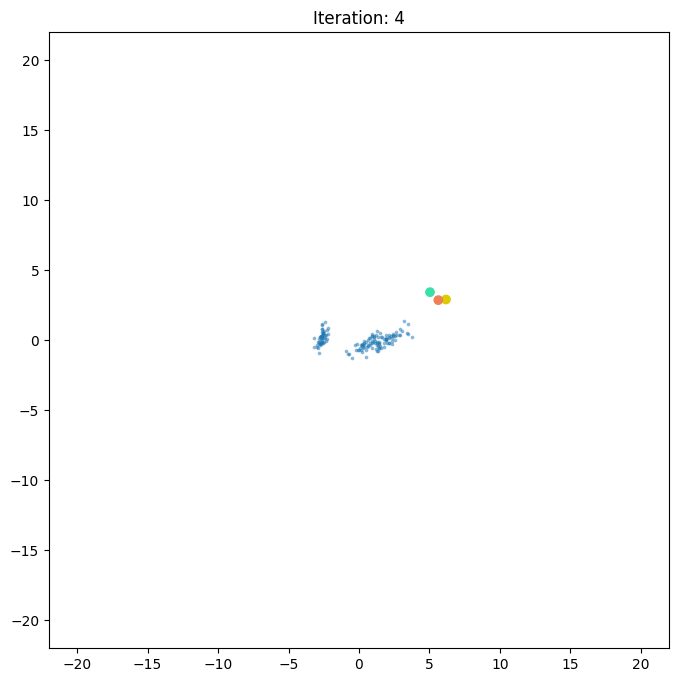

[[[ 0.45269466  0.11603513  0.49068692  0.18030389]
  [ 0.11603513  0.10943198  0.13160647  0.07527137]
  [ 0.49068692  0.13160647  0.77513778  0.32276836]
  [ 0.18030389  0.07527137  0.32276836  0.19318019]]

 [[ 0.30816385 -0.00424331  0.54882646  0.2192791 ]
  [-0.00424331  0.15886554 -0.14974329 -0.03502443]
  [ 0.54882646 -0.14974329  1.39465471  0.55741212]
  [ 0.2192791  -0.03502443  0.55741212  0.24370139]]

 [[ 0.12197043  0.09602715  0.0154636   0.01032033]
  [ 0.09602715  0.13703004  0.01059518  0.00921799]
  [ 0.0154636   0.01059518  0.02936099  0.00554382]
  [ 0.01032033  0.00921799  0.00554382  0.00975794]]]
Iteration: 5, log-likelihood: -216.7955
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

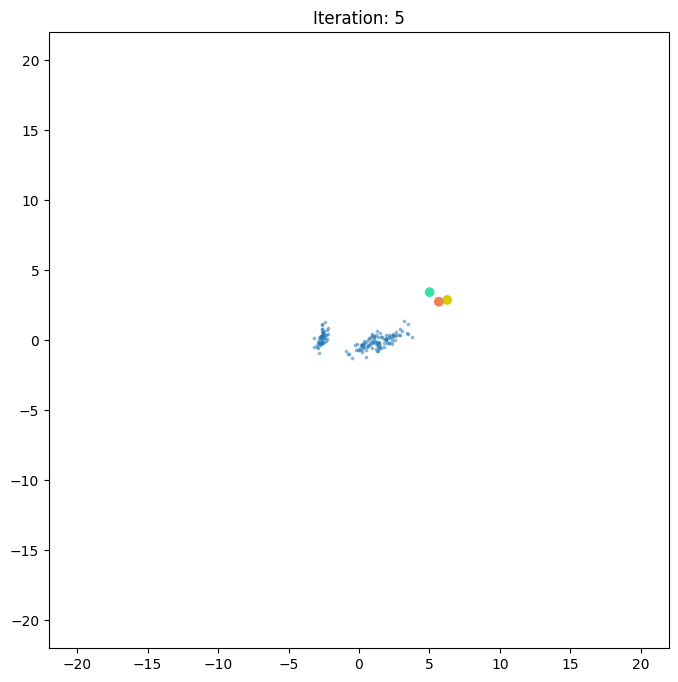

[[[ 0.43447101  0.11873725  0.44499056  0.16274253]
  [ 0.11873725  0.1076948   0.13833828  0.07772554]
  [ 0.44499056  0.13833828  0.66845774  0.28253917]
  [ 0.16274253  0.07772554  0.28253917  0.17819125]]

 [[ 0.25012845  0.01048938  0.41122554  0.15072364]
  [ 0.01048938  0.15535349 -0.10687143 -0.01082388]
  [ 0.41122554 -0.10687143  0.99991946  0.3606741 ]
  [ 0.15072364 -0.01082388  0.3606741   0.14853829]]

 [[ 0.12213327  0.09757024  0.0158966   0.010147  ]
  [ 0.09757024  0.14106192  0.01146327  0.00910445]
  [ 0.0158966   0.01146327  0.02942886  0.00574524]
  [ 0.010147    0.00910445  0.00574524  0.01045617]]]
Iteration: 6, log-likelihood: -214.3538
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

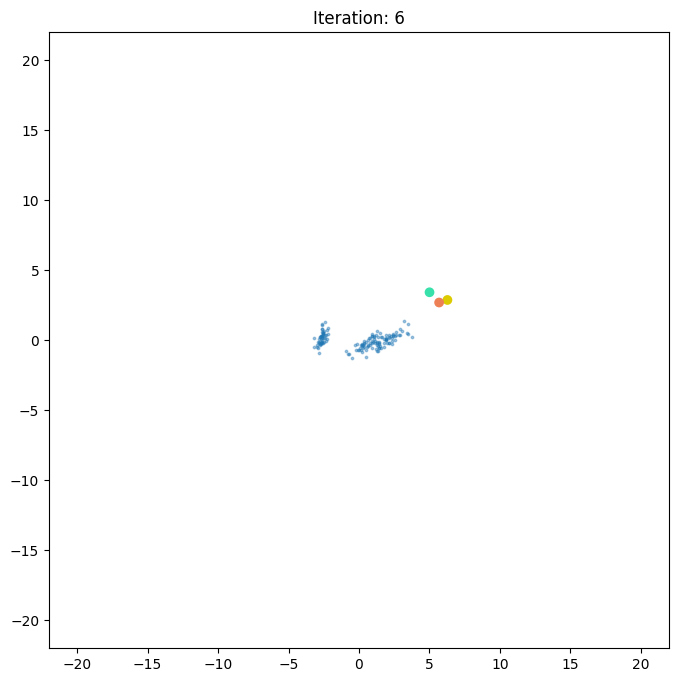

[[[ 0.43317458  0.11778654  0.44213884  0.16151328]
  [ 0.11778654  0.10694807  0.13729028  0.0770872 ]
  [ 0.44213884  0.13729028  0.66367901  0.28088082]
  [ 0.16151328  0.0770872   0.28088082  0.17769562]]

 [[ 0.21228954  0.04028675  0.29786157  0.10233196]
  [ 0.04028675  0.13161099 -0.02845158  0.01514664]
  [ 0.29786157 -0.02845158  0.63506872  0.21135968]
  [ 0.10233196  0.01514664  0.21135968  0.08418861]]

 [[ 0.12197072  0.09735686  0.01602066  0.01014563]
  [ 0.09735686  0.14088844  0.0114509   0.00910843]
  [ 0.01602066  0.0114509   0.02954865  0.00585811]
  [ 0.01014563  0.00910843  0.00585811  0.01067156]]]
Iteration: 7, log-likelihood: -213.1819
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

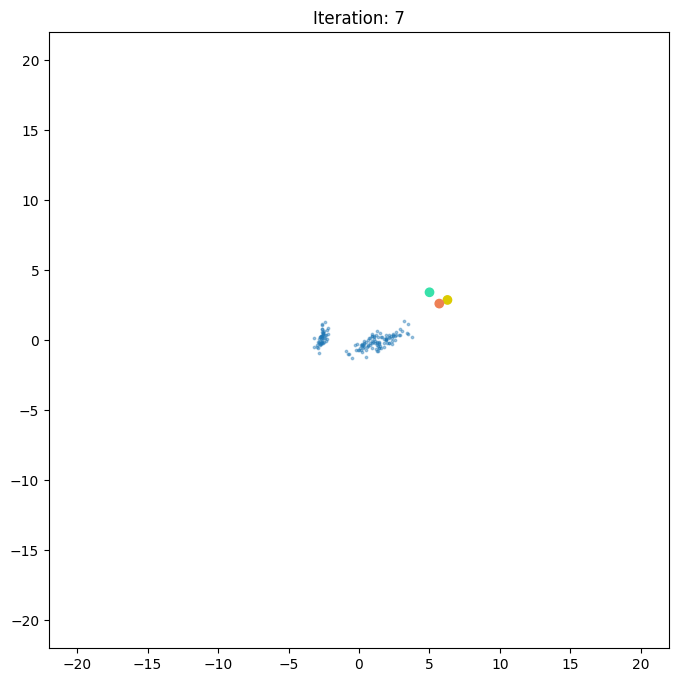

[[[0.42951137 0.11428515 0.43606908 0.15823038]
  [0.11428515 0.10490572 0.13310255 0.07503636]
  [0.43606908 0.13310255 0.65580054 0.27708745]
  [0.15823038 0.07503636 0.27708745 0.1763742 ]]

 [[0.20230611 0.0706096  0.23443046 0.07966178]
  [0.0706096  0.10587909 0.03833064 0.03129945]
  [0.23443046 0.03833064 0.39556247 0.12897804]
  [0.07966178 0.03129945 0.12897804 0.05162306]]

 [[0.12177199 0.0972047  0.01602421 0.01012908]
  [0.0972047  0.14073339 0.01144905 0.00911687]
  [0.01602421 0.01144905 0.02955736 0.00594185]
  [0.01012908 0.00911687 0.00594185 0.01086646]]]
Iteration: 8, log-likelihood: -210.9522
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

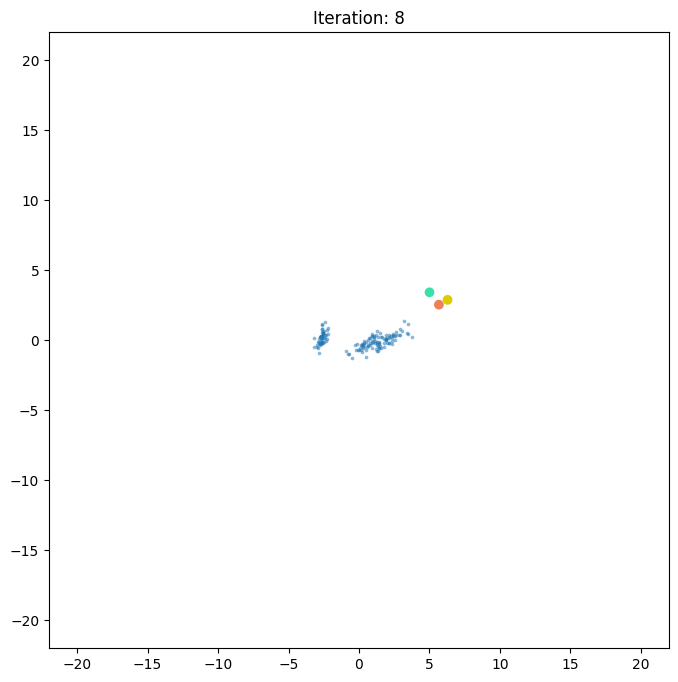

[[[0.41891561 0.10555826 0.4202109  0.14968447]
  [0.10555826 0.10073342 0.12209752 0.07008715]
  [0.4202109  0.12209752 0.6366636  0.26719537]
  [0.14968447 0.07008715 0.26719537 0.1726698 ]]

 [[0.20245935 0.08517263 0.20733465 0.07196078]
  [0.08517263 0.09398464 0.05468347 0.03162402]
  [0.20733465 0.05468347 0.29916028 0.09963709]
  [0.07196078 0.03162402 0.09963709 0.03983747]]

 [[0.12176263 0.09722715 0.01602732 0.01012438]
  [0.09722715 0.14080441 0.01146224 0.00911272]
  [0.01602732 0.01146224 0.02955603 0.00594815]
  [0.01012438 0.00911272 0.00594815 0.01088407]]]
Iteration: 9, log-likelihood: -207.7825
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

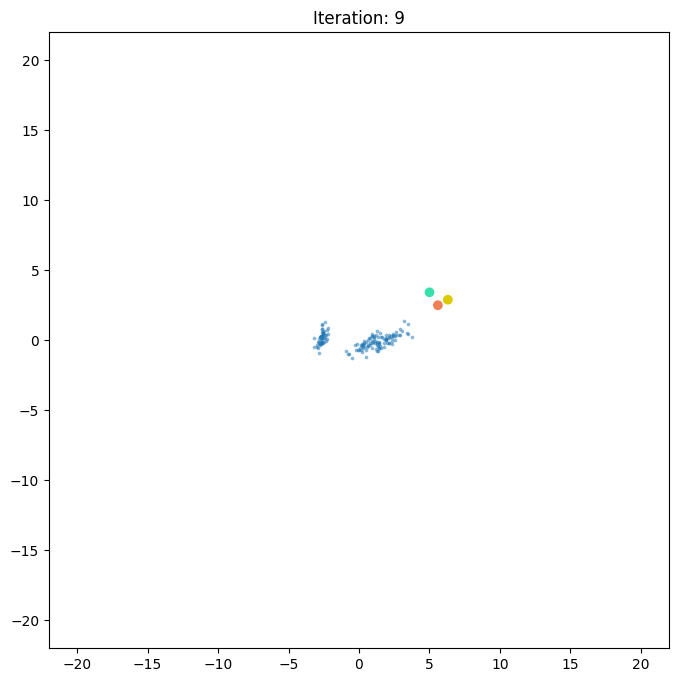

[[[0.40642022 0.09574697 0.40012244 0.13859434]
  [0.09574697 0.09712717 0.10875682 0.06424449]
  [0.40012244 0.10875682 0.61035126 0.25300921]
  [0.13859434 0.06424449 0.25300921 0.16706843]]

 [[0.19458575 0.08866776 0.17630918 0.06233145]
  [0.08866776 0.08136516 0.05745955 0.02839393]
  [0.17630918 0.05745955 0.22265593 0.07738201]
  [0.06233145 0.02839393 0.07738201 0.03167655]]

 [[0.12176325 0.09722935 0.01602763 0.01012421]
  [0.09722935 0.14080967 0.01146304 0.00911239]
  [0.01602763 0.01146304 0.02955602 0.00594808]
  [0.01012421 0.00911239 0.00594808 0.01088404]]]
Iteration: 10, log-likelihood: -204.2985
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

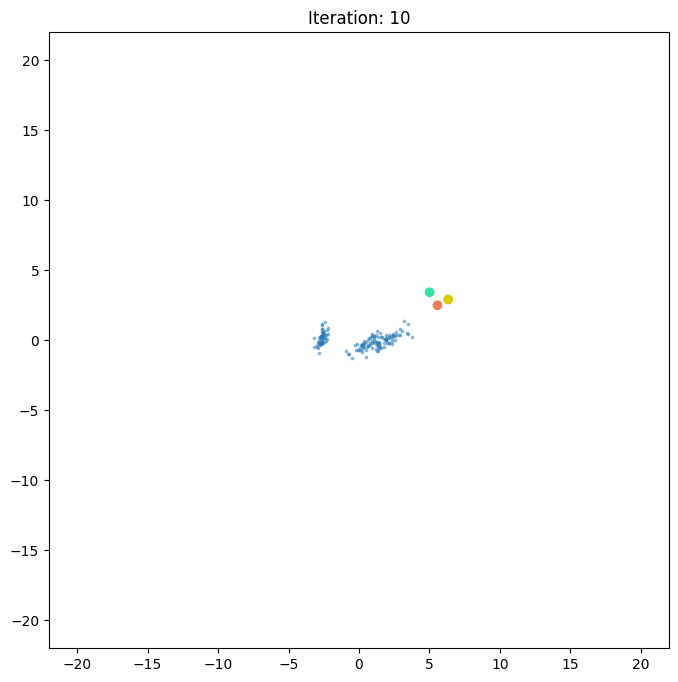

[[[0.39960323 0.08979437 0.38642623 0.13063722]
  [0.08979437 0.09638256 0.09905725 0.06029682]
  [0.38642623 0.09905725 0.58761788 0.24004779]
  [0.13063722 0.06029682 0.24004779 0.1616736 ]]

 [[0.20560422 0.10031113 0.16165031 0.05771088]
  [0.10031113 0.07605757 0.06832816 0.02948332]
  [0.16165031 0.06832816 0.17029737 0.06243635]
  [0.05771088 0.02948332 0.06243635 0.02667974]]

 [[0.12176358 0.09723052 0.01602779 0.01012412]
  [0.09723052 0.14081246 0.01146346 0.00911222]
  [0.01602779 0.01146346 0.02955601 0.00594805]
  [0.01012412 0.00911222 0.00594805 0.01088402]]]
Iteration: 11, log-likelihood: -200.2684
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

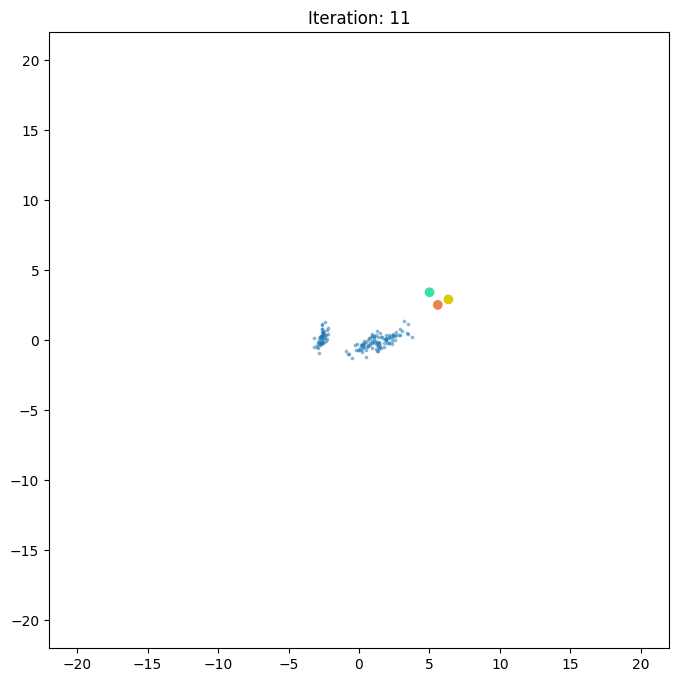

[[[0.40019797 0.08782629 0.38514829 0.12911258]
  [0.08782629 0.09775979 0.09584908 0.05960986]
  [0.38514829 0.09584908 0.57574204 0.23224528]
  [0.12911258 0.05960986 0.23224528 0.15855241]]

 [[0.27016957 0.13577867 0.18955095 0.06779863]
  [0.13577867 0.08615808 0.09433868 0.03748805]
  [0.18955095 0.09433868 0.16149013 0.06066963]
  [0.06779863 0.03748805 0.06066963 0.02624892]]

 [[0.12176379 0.09723125 0.0160279  0.01012406]
  [0.09723125 0.14081421 0.01146373 0.00911211]
  [0.0160279  0.01146373 0.029556   0.00594802]
  [0.01012406 0.00911211 0.00594802 0.01088401]]]
Iteration: 12, log-likelihood: -194.2714
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

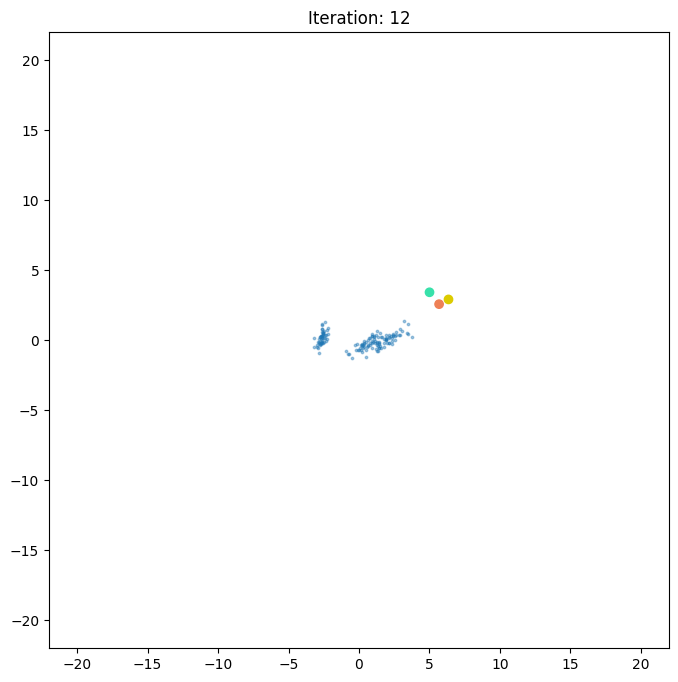

[[[0.40916556 0.08842975 0.40309879 0.13694846]
  [0.08842975 0.1005395  0.1009794  0.06321109]
  [0.40309879 0.1009794  0.58000579 0.23096112]
  [0.13694846 0.06321109 0.23096112 0.15859495]]

 [[0.37279587 0.18370693 0.25074685 0.08932602]
  [0.18370693 0.10500941 0.12365753 0.04752083]
  [0.25074685 0.12365753 0.19345451 0.07101246]
  [0.08932602 0.04752083 0.07101246 0.02949771]]

 [[0.12176389 0.09723161 0.01602795 0.01012403]
  [0.09723161 0.14081508 0.01146386 0.00911206]
  [0.01602795 0.01146386 0.029556   0.00594801]
  [0.01012403 0.00911206 0.00594801 0.01088401]]]
Iteration: 13, log-likelihood: -188.7132
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

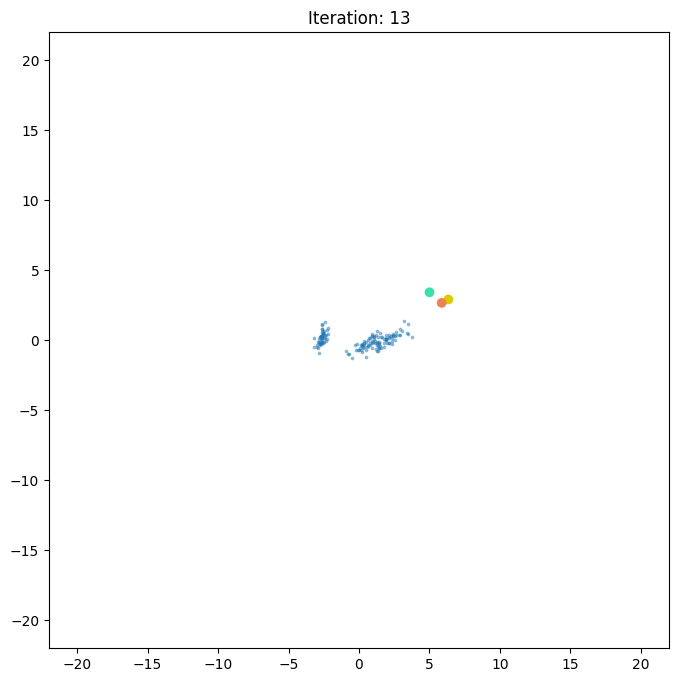

[[[0.41791361 0.09066204 0.41929519 0.1444494 ]
  [0.09066204 0.10330802 0.10640272 0.06644451]
  [0.41929519 0.10640272 0.58631946 0.23152328]
  [0.1444494  0.06644451 0.23152328 0.15893337]]

 [[0.39847823 0.19225979 0.27146071 0.09599049]
  [0.19225979 0.10622839 0.1304896  0.04988123]
  [0.27146071 0.1304896  0.2083326  0.07476865]
  [0.09599049 0.04988123 0.07476865 0.03043449]]

 [[0.12176395 0.09723183 0.01602798 0.01012401]
  [0.09723183 0.14081561 0.01146394 0.00911202]
  [0.01602798 0.01146394 0.029556   0.00594801]
  [0.01012401 0.00911202 0.00594801 0.010884  ]]]
Iteration: 14, log-likelihood: -187.0228
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

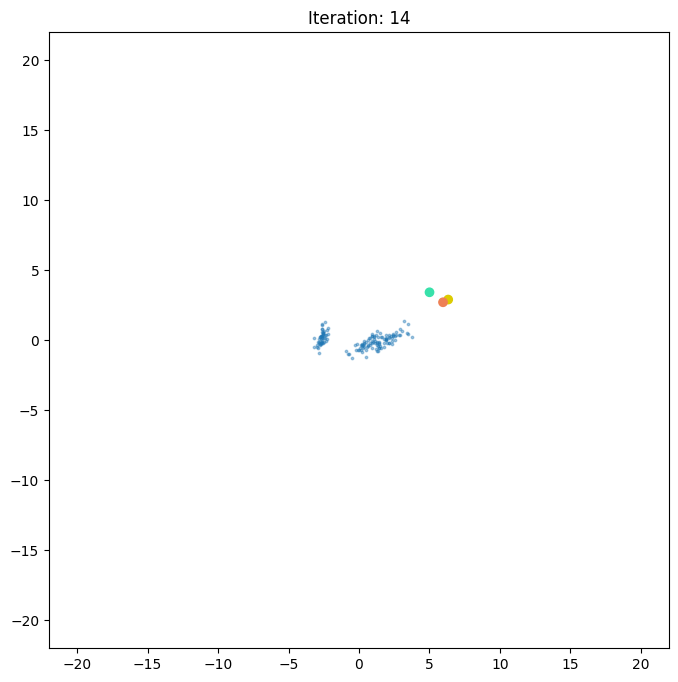

[[[0.42205222 0.09261088 0.42635283 0.14796557]
  [0.09261088 0.10482538 0.10903352 0.06774978]
  [0.42635283 0.10903352 0.59021081 0.23226181]
  [0.14796557 0.06774978 0.23226181 0.15888383]]

 [[0.40259476 0.1905573  0.2788271  0.09758105]
  [0.1905573  0.10387223 0.13091294 0.05003741]
  [0.2788271  0.13091294 0.2155088  0.07589675]
  [0.09758105 0.05003741 0.07589675 0.03051432]]

 [[0.12176398 0.09723192 0.01602799 0.01012401]
  [0.09723192 0.14081582 0.01146397 0.00911201]
  [0.01602799 0.01146397 0.029556   0.005948  ]
  [0.01012401 0.00911201 0.005948   0.010884  ]]]
Iteration: 15, log-likelihood: -186.5399
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

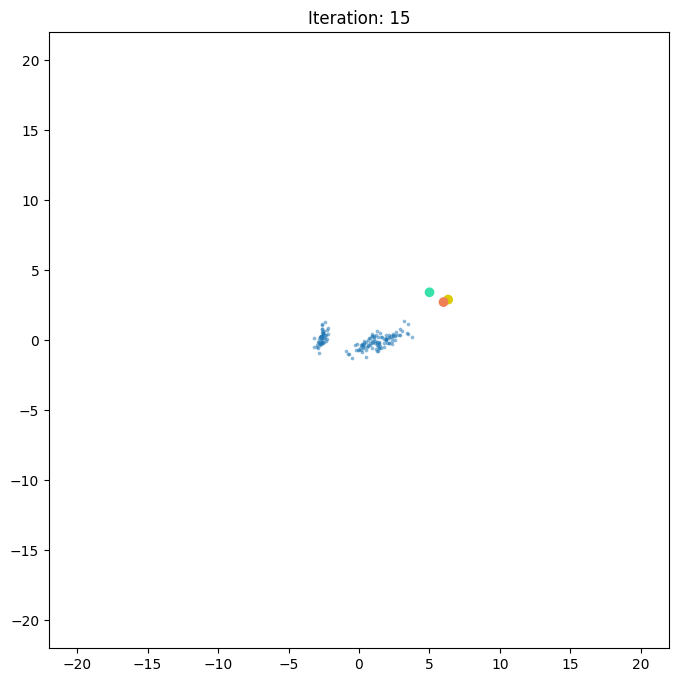

[[[0.42367539 0.09383659 0.42963892 0.14980021]
  [0.09383659 0.10555383 0.11050543 0.06838201]
  [0.42963892 0.11050543 0.59282257 0.23310354]
  [0.14980021 0.06838201 0.23310354 0.15894583]]

 [[0.40613974 0.18958063 0.28412687 0.09874864]
  [0.18958063 0.1026568  0.13107214 0.05016739]
  [0.28412687 0.13107214 0.22031566 0.07659718]
  [0.09874864 0.05016739 0.07659718 0.03050088]]

 [[0.12176398 0.09723194 0.01602799 0.010124  ]
  [0.09723194 0.14081587 0.01146398 0.00911201]
  [0.01602799 0.01146398 0.029556   0.005948  ]
  [0.010124   0.00911201 0.005948   0.010884  ]]]
Iteration: 16, log-likelihood: -186.3398
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

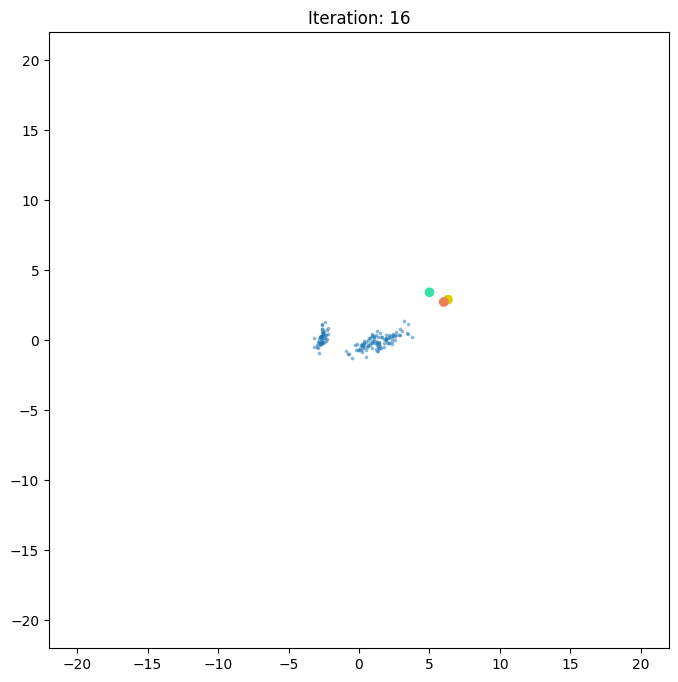

[[[0.4243965  0.0946047  0.43140397 0.1508725 ]
  [0.0946047  0.105912   0.11144163 0.0687571 ]
  [0.43140397 0.11144163 0.59461994 0.23385296]
  [0.1508725  0.0687571  0.23385296 0.15907676]]

 [[0.40905189 0.1893702  0.28797774 0.09973171]
  [0.1893702  0.10222485 0.13138384 0.0503701 ]
  [0.28797774 0.13138384 0.22360094 0.077121  ]
  [0.09973171 0.0503701  0.077121   0.03050451]]

 [[0.12176398 0.09723195 0.01602799 0.010124  ]
  [0.09723195 0.14081587 0.01146398 0.00911201]
  [0.01602799 0.01146398 0.029556   0.005948  ]
  [0.010124   0.00911201 0.005948   0.010884  ]]]
Iteration: 17, log-likelihood: -186.2470
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

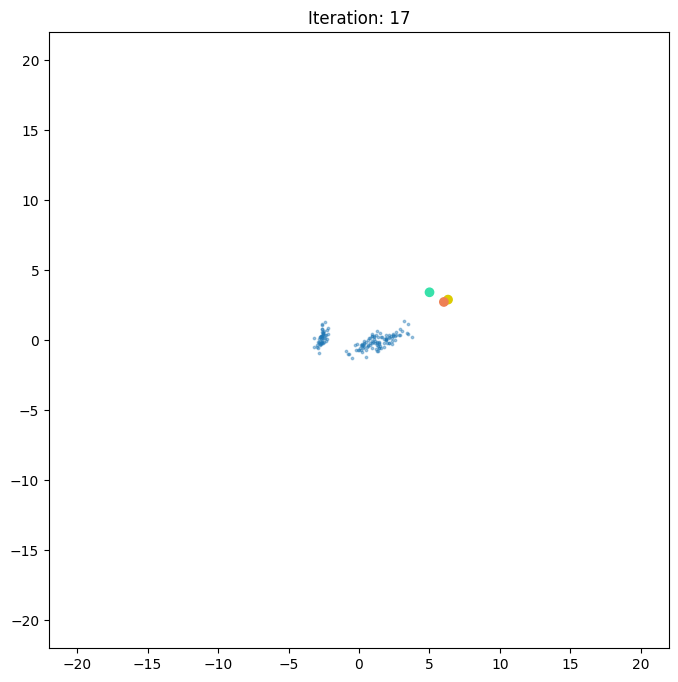

[[[0.42478819 0.09511243 0.4324825  0.15155523]
  [0.09511243 0.10610078 0.11208728 0.0690076 ]
  [0.4324825  0.11208728 0.59595518 0.23448933]
  [0.15155523 0.0690076  0.23448933 0.15922377]]

 [[0.41117748 0.1895231  0.29065989 0.10051252]
  [0.1895231  0.10213745 0.13176081 0.05058291]
  [0.29065989 0.13176081 0.22578768 0.07750301]
  [0.10051252 0.05058291 0.07750301 0.03052023]]

 [[0.12176399 0.09723195 0.01602799 0.010124  ]
  [0.09723195 0.14081588 0.01146398 0.00911201]
  [0.01602799 0.01146398 0.029556   0.005948  ]
  [0.010124   0.00911201 0.005948   0.010884  ]]]
Iteration: 18, log-likelihood: -186.2005
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

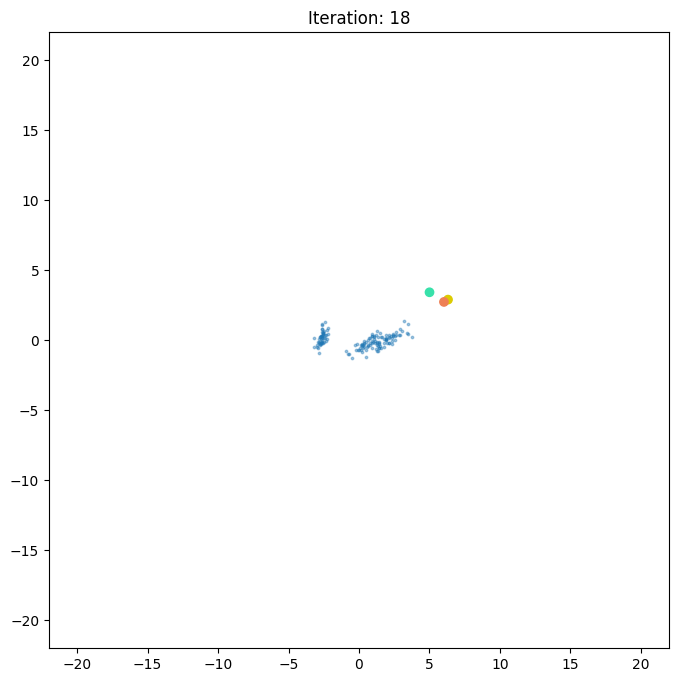

[[[0.42502695 0.09546862 0.43320461 0.15202239]
  [0.09546862 0.10621224 0.11255869 0.06918872]
  [0.43320461 0.11255869 0.59702171 0.23503694]
  [0.15202239 0.06918872 0.23503694 0.15937032]]

 [[0.41275479 0.18982326 0.29256459 0.10112613]
  [0.18982326 0.10216286 0.13213018 0.05076463]
  [0.29256459 0.13213018 0.22726757 0.07778096]
  [0.10112613 0.05076463 0.07778096 0.03053446]]

 [[0.12176398 0.09723195 0.01602799 0.010124  ]
  [0.09723195 0.14081587 0.01146398 0.00911201]
  [0.01602799 0.01146398 0.029556   0.005948  ]
  [0.010124   0.00911201 0.005948   0.010884  ]]]
Iteration: 19, log-likelihood: -186.1745
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

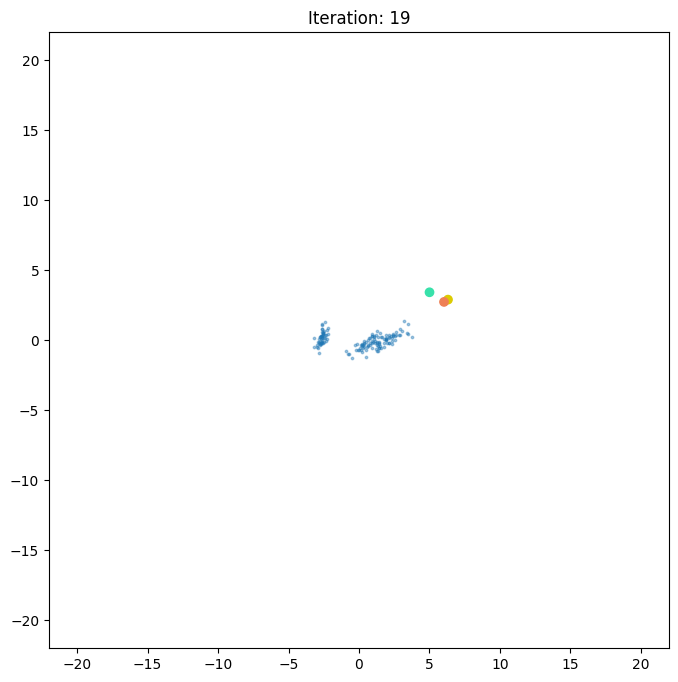

[[[0.42517574 0.09573004 0.43371904 0.15236184]
  [0.09573004 0.10628579 0.11291366 0.06932514]
  [0.43371904 0.11291366 0.5979145  0.23551477]
  [0.15236184 0.06932514 0.23551477 0.15950938]]

 [[0.41400974 0.1901754  0.29399235 0.10161796]
  [0.1901754  0.10220602 0.1324634  0.05090269]
  [0.29399235 0.1324634  0.22831978 0.07798901]
  [0.10161796 0.05090269 0.07798901 0.03054151]]

 [[0.12176398 0.09723195 0.01602799 0.010124  ]
  [0.09723195 0.14081587 0.01146398 0.00911201]
  [0.01602799 0.01146398 0.029556   0.005948  ]
  [0.010124   0.00911201 0.005948   0.010884  ]]]
Iteration: 20, log-likelihood: -186.1582
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

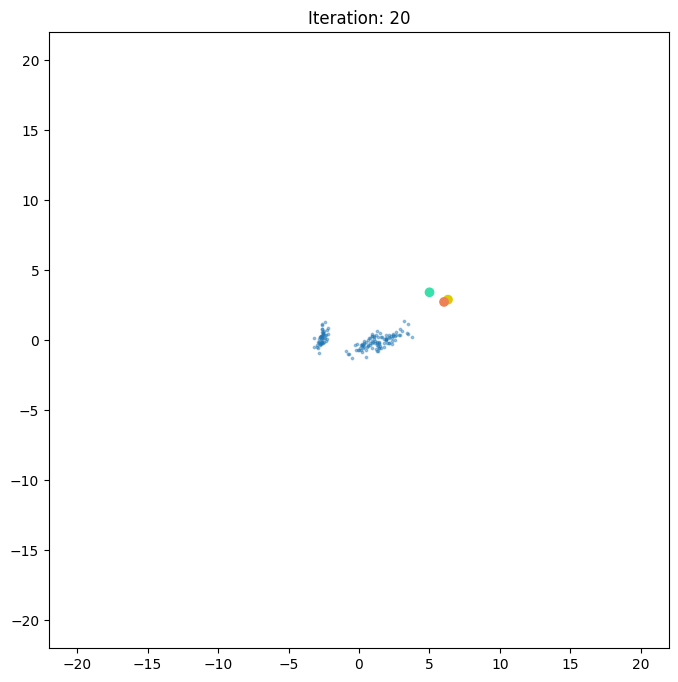

[[[0.42526255 0.09592643 0.43409916 0.15261929]
  [0.09592643 0.10633672 0.11318207 0.06942797]
  [0.43409916 0.11318207 0.59868051 0.23593438]
  [0.15261929 0.06942797 0.23593438 0.15963682]]

 [[0.4150865  0.19054542 0.29513306 0.10202616]
  [0.19054542 0.10223878 0.13275822 0.05100056]
  [0.29513306 0.13275822 0.22911657 0.07815211]
  [0.10202616 0.05100056 0.07815211 0.03054118]]

 [[0.12176398 0.09723194 0.01602799 0.010124  ]
  [0.09723194 0.14081587 0.01146398 0.00911201]
  [0.01602799 0.01146398 0.029556   0.005948  ]
  [0.010124   0.00911201 0.005948   0.010884  ]]]
Iteration: 21, log-likelihood: -186.1467
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

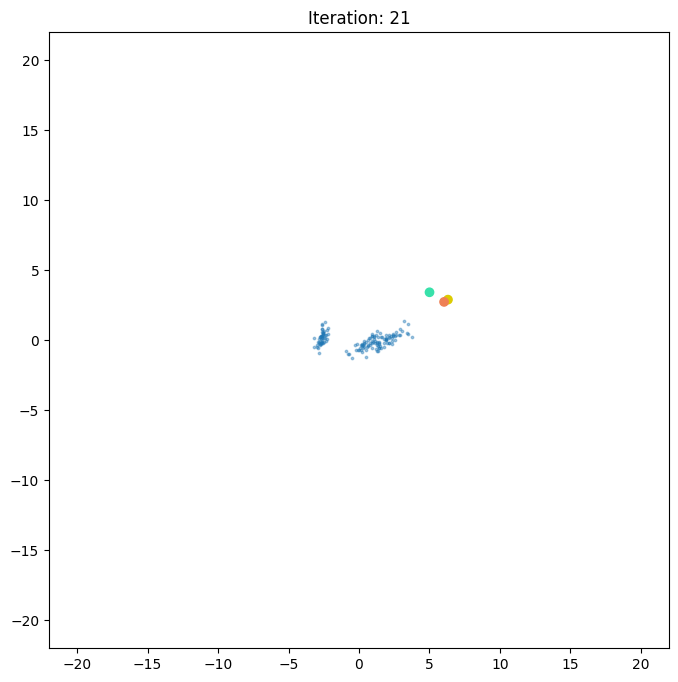

[[[0.42530192 0.09607467 0.43438432 0.15281995]
  [0.09607467 0.10637077 0.11338153 0.06950289]
  [0.43438432 0.11338153 0.59934662 0.23630446]
  [0.15281995 0.06950289 0.23630446 0.15975067]]

 [[0.41607307 0.1909261  0.29610393 0.10237948]
  [0.1909261  0.10225866 0.13302276 0.05106679]
  [0.29610393 0.13302276 0.229762   0.07828716]
  [0.10237948 0.05106679 0.07828716 0.03053493]]

 [[0.12176398 0.09723194 0.01602799 0.010124  ]
  [0.09723194 0.14081586 0.01146398 0.00911201]
  [0.01602799 0.01146398 0.029556   0.005948  ]
  [0.010124   0.00911201 0.005948   0.010884  ]]]
Iteration: 22, log-likelihood: -186.1374
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

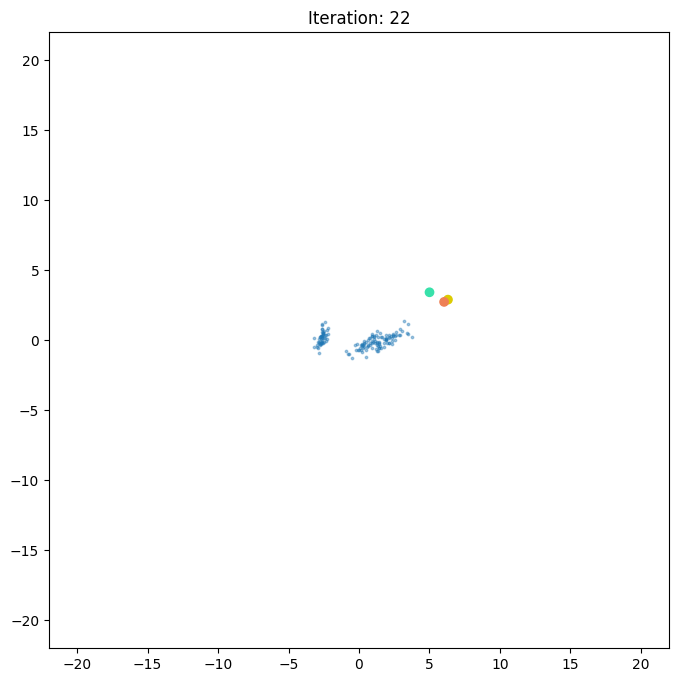

[[[0.42530247 0.0961857  0.43459816 0.15297924]
  [0.0961857  0.10639052 0.11352437 0.0695538 ]
  [0.43459816 0.11352437 0.59993276 0.23663338]
  [0.15297924 0.0695538  0.23663338 0.15985083]]

 [[0.41702616 0.19132019 0.29698012 0.10269904]
  [0.19132019 0.10226986 0.13326716 0.05110959]
  [0.29698012 0.13326716 0.23032078 0.07840531]
  [0.10269904 0.05110959 0.07840531 0.03052411]]

 [[0.12176398 0.09723194 0.01602799 0.010124  ]
  [0.09723194 0.14081586 0.01146398 0.00911201]
  [0.01602799 0.01146398 0.029556   0.005948  ]
  [0.010124   0.00911201 0.005948   0.010884  ]]]
Iteration: 23, log-likelihood: -186.1291
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

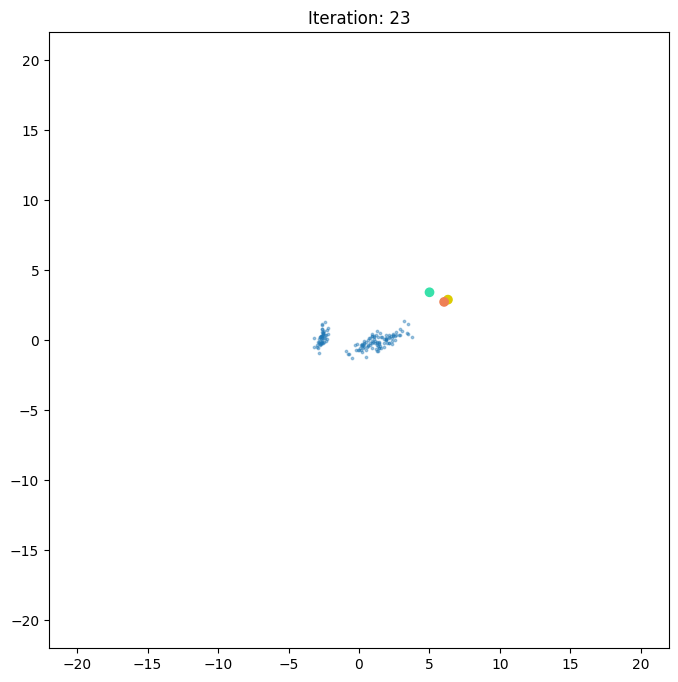

[[[0.42526979 0.0962676  0.43475667 0.15310773]
  [0.0962676  0.10639763 0.11362036 0.06958387]
  [0.43475667 0.11362036 0.60045698 0.23693002]
  [0.15310773 0.06958387 0.23693002 0.15993857]]

 [[0.41798589 0.19173361 0.29781281 0.10300051]
  [0.19173361 0.10227635 0.13350041 0.05113505]
  [0.29781281 0.13350041 0.23083503 0.07851392]
  [0.10300051 0.05113505 0.07851392 0.03050941]]

 [[0.12176398 0.09723194 0.01602799 0.010124  ]
  [0.09723194 0.14081585 0.01146398 0.00911201]
  [0.01602799 0.01146398 0.029556   0.005948  ]
  [0.010124   0.00911201 0.005948   0.010884  ]]]
Iteration: 24, log-likelihood: -186.1207
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

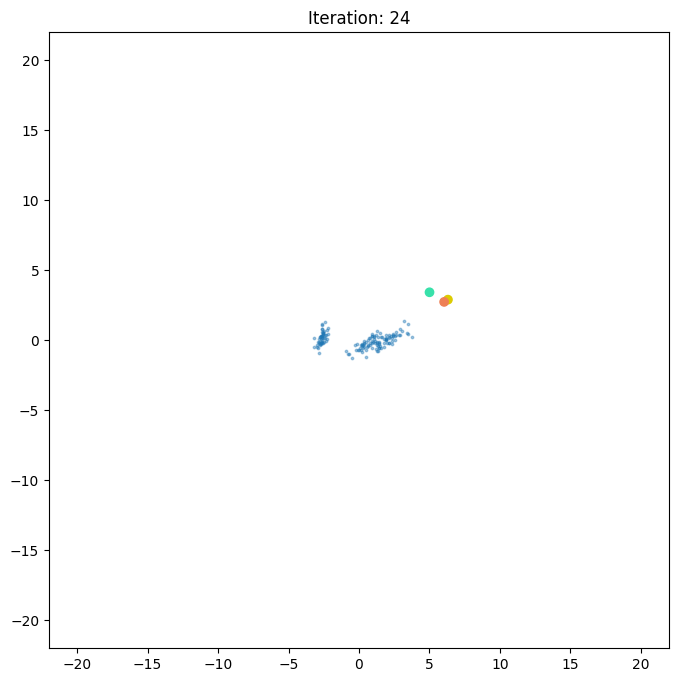

[[[0.42520754 0.09632675 0.43487167 0.15321338]
  [0.09632675 0.1063935  0.11367744 0.06959583]
  [0.43487167 0.11367744 0.60093695 0.23720372]
  [0.15321338 0.06959583 0.23720372 0.16001601]]

 [[0.41898429 0.19217339 0.29863959 0.10329603]
  [0.19217339 0.10228    0.13372981 0.05114701]
  [0.29863959 0.13372981 0.23133365 0.07861785]
  [0.10329603 0.05114701 0.07861785 0.03049085]]

 [[0.12176398 0.09723194 0.01602799 0.01012401]
  [0.09723194 0.14081585 0.01146398 0.00911201]
  [0.01602799 0.01146398 0.029556   0.005948  ]
  [0.01012401 0.00911201 0.005948   0.010884  ]]]
Iteration: 25, log-likelihood: -186.1115
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

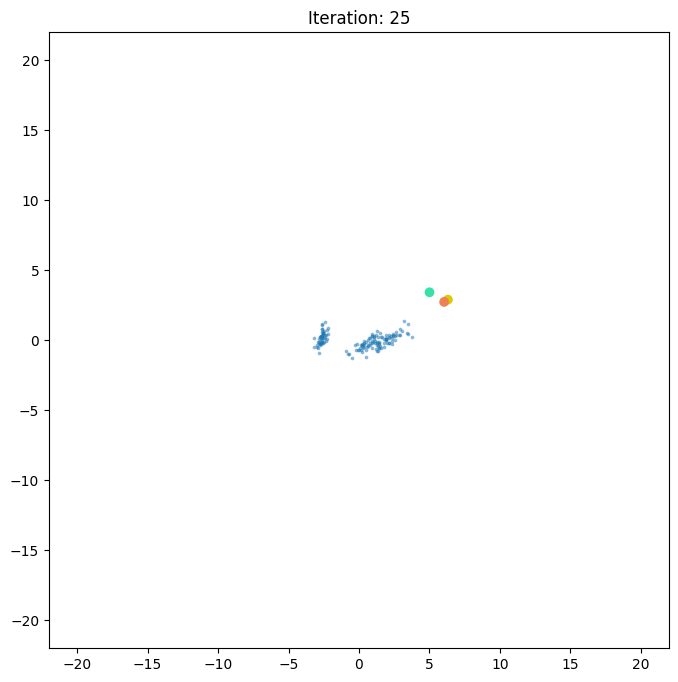

[[[0.42511786 0.09636839 0.43495229 0.1533025 ]
  [0.09636839 0.10637933 0.11370197 0.06959186]
  [0.43495229 0.11370197 0.6013905  0.23746415]
  [0.1533025  0.06959186 0.23746415 0.16008574]]

 [[0.42005051 0.19264755 0.29949075 0.10359555]
  [0.19264755 0.10228073 0.13396123 0.05114731]
  [0.29949075 0.13396123 0.23183778 0.07872026]
  [0.10359555 0.05114731 0.07872026 0.03046774]]

 [[0.12176398 0.09723193 0.01602799 0.01012401]
  [0.09723193 0.14081584 0.01146398 0.00911201]
  [0.01602799 0.01146398 0.029556   0.005948  ]
  [0.01012401 0.00911201 0.005948   0.010884  ]]]
Iteration: 26, log-likelihood: -186.1007
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

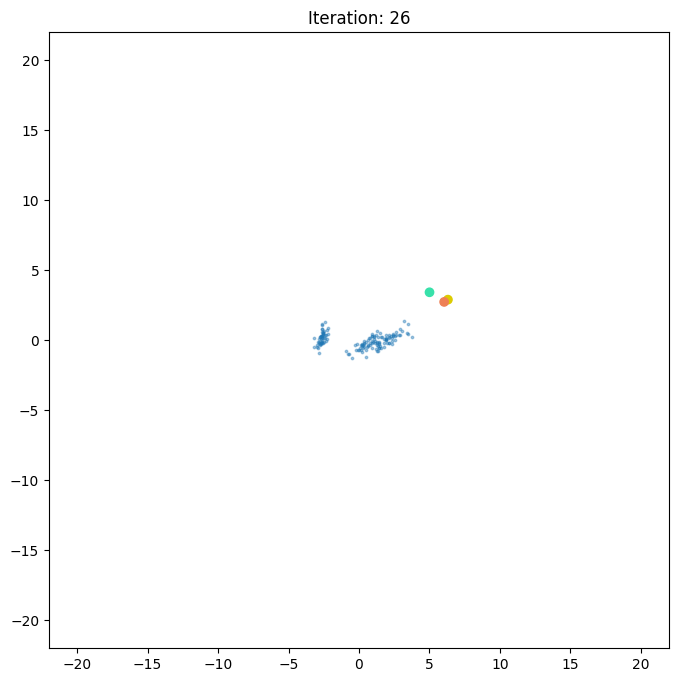

[[[0.42500166 0.09639692 0.43500593 0.15338041]
  [0.09639692 0.10635604 0.11369897 0.06957356]
  [0.43500593 0.11369897 0.60183605 0.23772142]
  [0.15338041 0.06957356 0.23772142 0.1601506 ]]

 [[0.4212139  0.1931654  0.30039293 0.10390783]
  [0.1931654  0.10227688 0.13419959 0.05113627]
  [0.30039293 0.13419959 0.23236383 0.07882308]
  [0.10390783 0.05113627 0.07882308 0.03043875]]

 [[0.12176398 0.09723193 0.01602799 0.01012401]
  [0.09723193 0.14081584 0.01146398 0.00911201]
  [0.01602799 0.01146398 0.029556   0.005948  ]
  [0.01012401 0.00911201 0.005948   0.010884  ]]]
Iteration: 27, log-likelihood: -186.0872
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

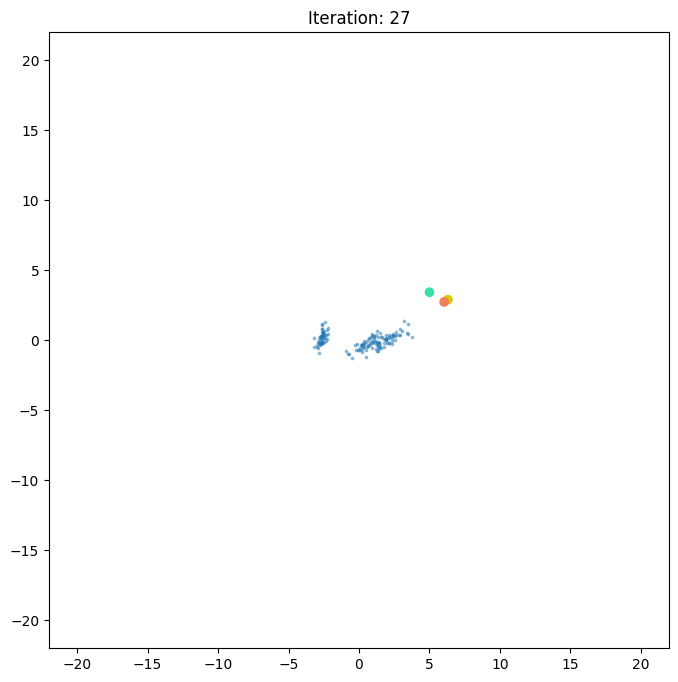

[[[0.42485921 0.09641633 0.43503937 0.15345203]
  [0.09641633 0.10632429 0.11367269 0.06954218]
  [0.43503937 0.11367269 0.60229382 0.23798656]
  [0.15345203 0.06954218 0.23798656 0.16021379]]

 [[0.42250495 0.19373768 0.30137056 0.10424087]
  [0.19373768 0.10226579 0.13444908 0.05111298]
  [0.30137056 0.13444908 0.23292445 0.07892695]
  [0.10424087 0.05111298 0.07892695 0.03040186]]

 [[0.12176398 0.09723193 0.01602799 0.01012401]
  [0.09723193 0.14081583 0.01146397 0.00911201]
  [0.01602799 0.01146397 0.029556   0.005948  ]
  [0.01012401 0.00911201 0.005948   0.010884  ]]]
Iteration: 28, log-likelihood: -186.0695
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

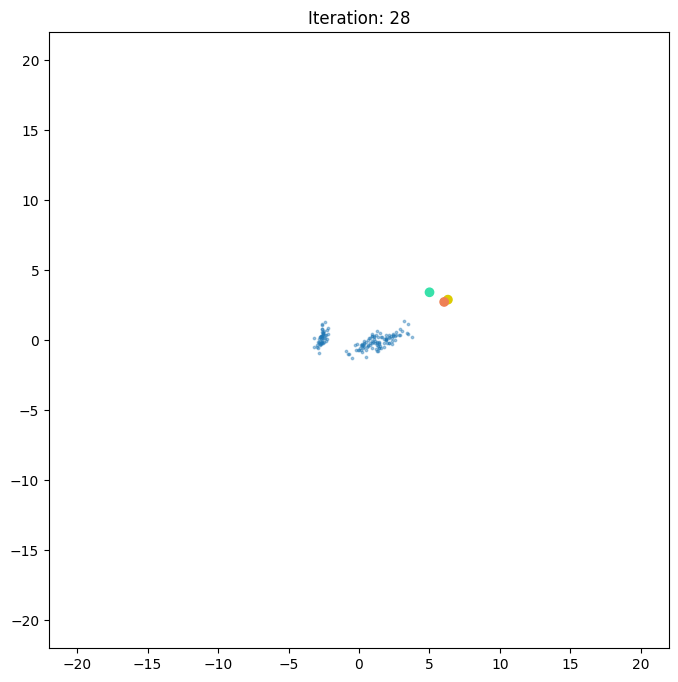

[[[0.42469159 0.09643083 0.43506075 0.15352274]
  [0.09643083 0.10628472 0.11362789 0.06949916]
  [0.43506075 0.11362789 0.60278795 0.23827241]
  [0.15352274 0.06949916 0.23827241 0.16027937]]

 [[0.4239522  0.19437564 0.30244388 0.10460145]
  [0.19437564 0.10224463 0.13471304 0.05107585]
  [0.30244388 0.13471304 0.23352676 0.07903078]
  [0.10460145 0.05107585 0.07903078 0.03035431]]

 [[0.12176398 0.09723193 0.01602799 0.01012401]
  [0.09723193 0.14081583 0.01146397 0.00911201]
  [0.01602799 0.01146397 0.029556   0.005948  ]
  [0.01012401 0.00911201 0.005948   0.010884  ]]]
Iteration: 29, log-likelihood: -186.0453
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

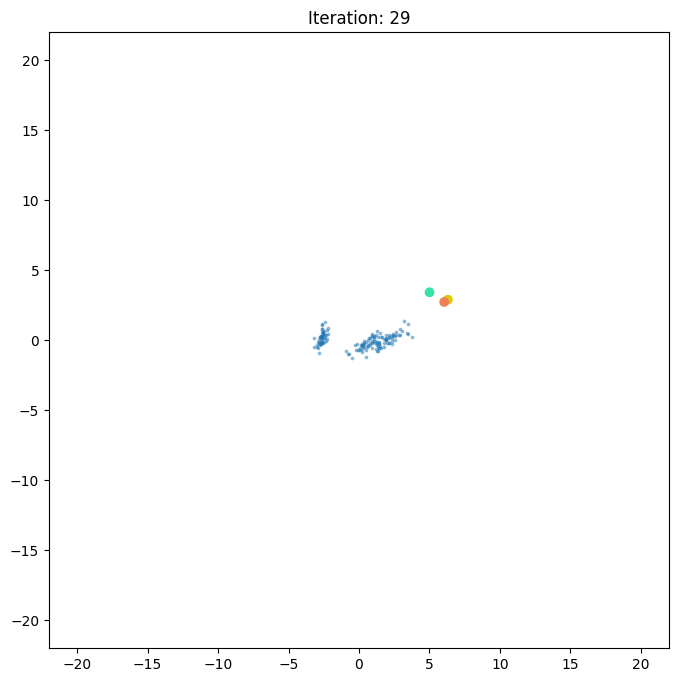

[[[0.4245039  0.09644594 0.43508341 0.15359989]
  [0.09644594 0.10623834 0.11357261 0.06944753]
  [0.43508341 0.11357261 0.60335016 0.23859517]
  [0.15359989 0.06944753 0.23859517 0.1603532 ]]

 [[0.42557116 0.19508796 0.30362078 0.1049931 ]
  [0.19508796 0.10221247 0.13499334 0.05102386]
  [0.30362078 0.13499334 0.23416598 0.07913039]
  [0.1049931  0.05102386 0.07913039 0.03029294]]

 [[0.12176398 0.09723192 0.01602799 0.01012401]
  [0.09723192 0.14081582 0.01146397 0.00911201]
  [0.01602799 0.01146397 0.029556   0.005948  ]
  [0.01012401 0.00911201 0.005948   0.010884  ]]]
Iteration: 30, log-likelihood: -186.0120
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

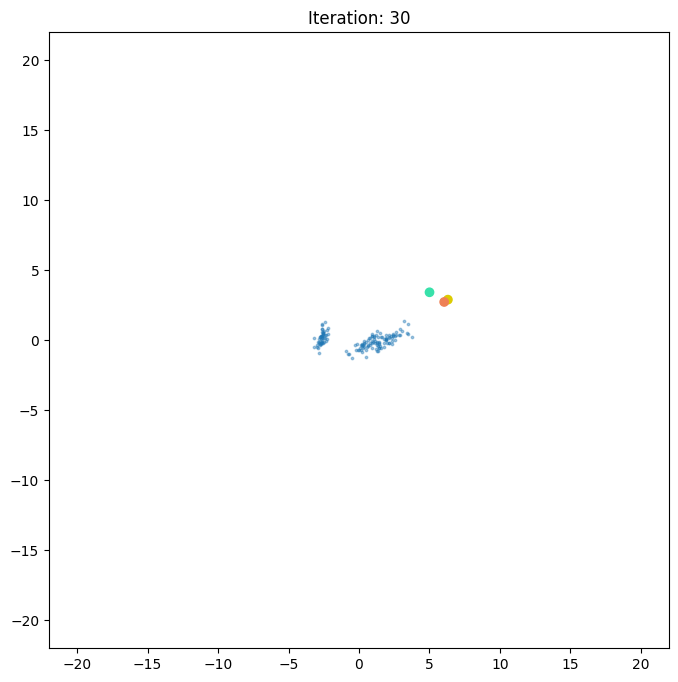

[[[0.42431136 0.09647013 0.43513271 0.15369523]
  [0.09647013 0.10618751 0.11352321 0.06939447]
  [0.43513271 0.11352321 0.60402498 0.23897636]
  [0.15369523 0.06939447 0.23897636 0.16044481]]

 [[0.42733876 0.19587374 0.30487782 0.1054112 ]
  [0.19587374 0.10217524 0.13528905 0.05095948]
  [0.30487782 0.13528905 0.23481147 0.07921624]
  [0.1054112  0.05095948 0.07921624 0.03021509]]

 [[0.12176398 0.09723192 0.01602799 0.01012401]
  [0.09723192 0.14081581 0.01146397 0.00911201]
  [0.01602799 0.01146397 0.029556   0.005948  ]
  [0.01012401 0.00911201 0.005948   0.010884  ]]]
Iteration: 31, log-likelihood: -185.9675
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

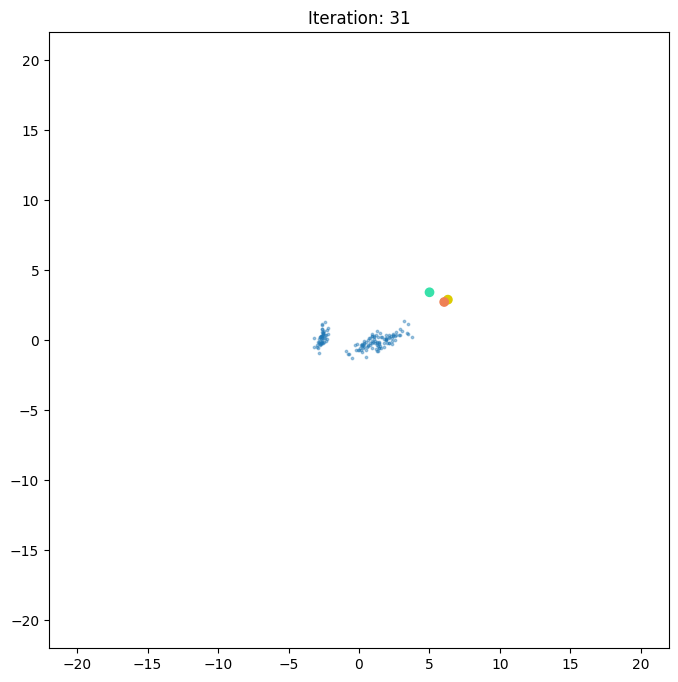

[[[0.4241469  0.0965163  0.43525388 0.15382749]
  [0.0965163  0.10613699 0.11351071 0.06935493]
  [0.43525388 0.11351071 0.6048744  0.23944438]
  [0.15382749 0.06935493 0.23944438 0.16056965]]

 [[0.42915498 0.1967116  0.30613155 0.10583522]
  [0.1967116  0.10215425 0.13559494 0.05089359]
  [0.30613155 0.13559494 0.23538612 0.0792703 ]
  [0.10583522 0.05089359 0.0792703  0.03012062]]

 [[0.12176398 0.09723192 0.01602799 0.01012401]
  [0.09723192 0.1408158  0.01146397 0.00911201]
  [0.01602799 0.01146397 0.029556   0.005948  ]
  [0.01012401 0.00911201 0.005948   0.010884  ]]]
Iteration: 32, log-likelihood: -185.9138
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

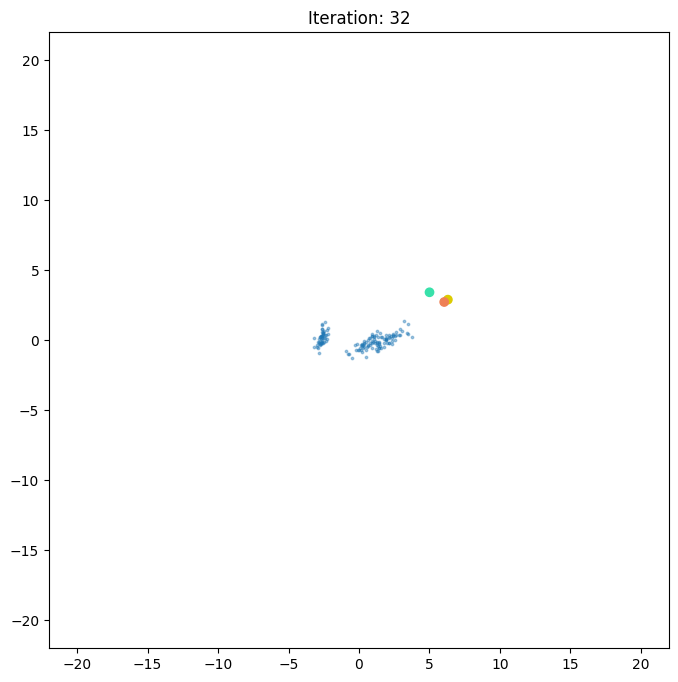

[[[0.42405837 0.09659961 0.43550795 0.15402037]
  [0.09659961 0.10609382 0.1135802  0.06935183]
  [0.43550795 0.1135802  0.60597129 0.24003156]
  [0.15402037 0.06935183 0.24003156 0.16074896]]

 [[0.43083375 0.19755516 0.30722902 0.10622419]
  [0.19755516 0.10219164 0.13590116 0.05084805]
  [0.30722902 0.13590116 0.2357591  0.07926485]
  [0.10622419 0.05084805 0.07926485 0.03001314]]

 [[0.12176397 0.09723191 0.01602799 0.01012401]
  [0.09723191 0.14081579 0.01146397 0.00911201]
  [0.01602799 0.01146397 0.029556   0.005948  ]
  [0.01012401 0.00911201 0.005948   0.010884  ]]]
Iteration: 33, log-likelihood: -185.8595
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

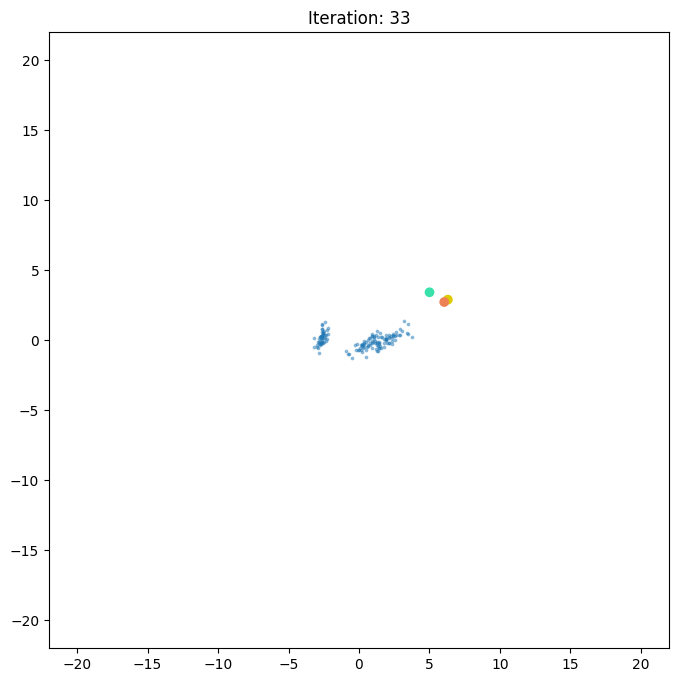

[[[0.42407513 0.09672628 0.43593366 0.15428795]
  [0.09672628 0.10606305 0.11376808 0.06940527]
  [0.43593366 0.11376808 0.60736508 0.24076036]
  [0.15428795 0.06940527 0.24076036 0.16100175]]

 [[0.43221603 0.19835906 0.30802536 0.10653263]
  [0.19835906 0.10233567 0.13619844 0.05084606]
  [0.30802536 0.13619844 0.23579876 0.07916987]
  [0.10653263 0.05084606 0.07916987 0.02989661]]

 [[0.12176397 0.0972319  0.01602799 0.01012401]
  [0.0972319  0.14081577 0.01146397 0.00911201]
  [0.01602799 0.01146397 0.029556   0.005948  ]
  [0.01012401 0.00911201 0.005948   0.010884  ]]]
Iteration: 34, log-likelihood: -185.8144
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

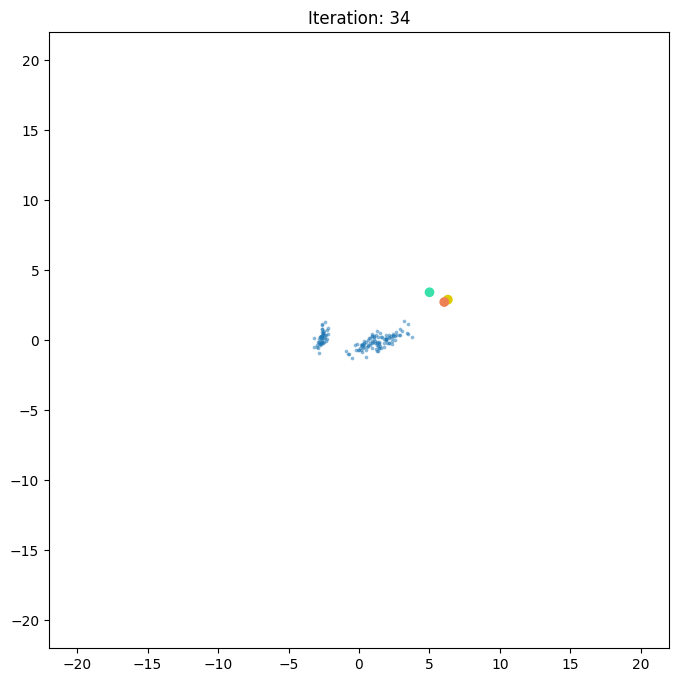

[[[0.42416108 0.0968803  0.43649725 0.15461647]
  [0.0968803  0.10604139 0.11406818 0.06951521]
  [0.43649725 0.11406818 0.60904053 0.24162686]
  [0.15461647 0.06951521 0.24162686 0.16133204]]

 [[0.43337671 0.19913404 0.30853691 0.10675062]
  [0.19913404 0.10261049 0.13649243 0.05089475]
  [0.30853691 0.13649243 0.23548033 0.07897179]
  [0.10675062 0.05089475 0.07897179 0.02976915]]

 [[0.12176397 0.0972319  0.01602799 0.01012401]
  [0.0972319  0.14081575 0.01146396 0.00911202]
  [0.01602799 0.01146396 0.029556   0.005948  ]
  [0.01012401 0.00911202 0.005948   0.010884  ]]]
Iteration: 35, log-likelihood: -185.7774
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

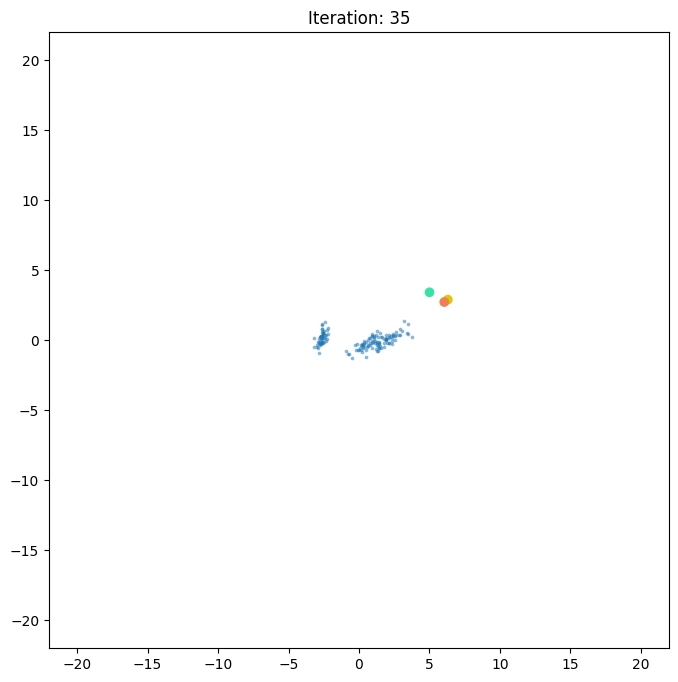

[[[0.42422779 0.09703147 0.43711556 0.15497553]
  [0.09703147 0.10601777 0.11444    0.06966373]
  [0.43711556 0.11444    0.61095337 0.24261701]
  [0.15497553 0.06966373 0.24261701 0.16173308]]

 [[0.43464628 0.19996448 0.30896915 0.10692129]
  [0.19996448 0.10301523 0.13681354 0.05098633]
  [0.30896915 0.13681354 0.23490451 0.0786802 ]
  [0.10692129 0.05098633 0.0786802  0.02962303]]

 [[0.12176397 0.09723189 0.01602798 0.01012401]
  [0.09723189 0.14081573 0.01146396 0.00911202]
  [0.01602798 0.01146396 0.029556   0.005948  ]
  [0.01012401 0.00911202 0.005948   0.010884  ]]]
Iteration: 36, log-likelihood: -185.7375
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

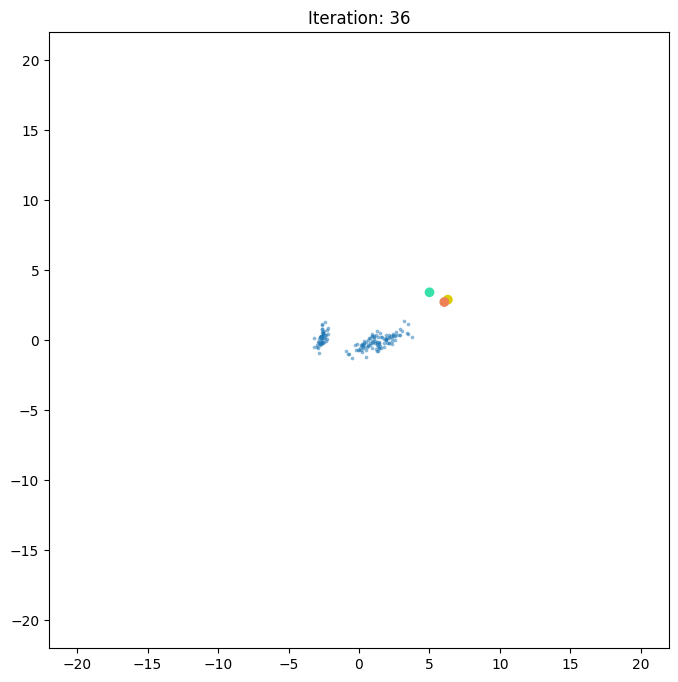

[[[0.42419894 0.09715977 0.43773755 0.15535187]
  [0.09715977 0.10598079 0.11485535 0.06983654]
  [0.43773755 0.11485535 0.61312813 0.24375034]
  [0.15535187 0.06983654 0.24375034 0.16220906]]

 [[0.4364064  0.20096666 0.30956433 0.10710618]
  [0.20096666 0.10355502 0.1372048  0.05111401]
  [0.30956433 0.1372048  0.2341769  0.07830297]
  [0.10710618 0.05111401 0.07830297 0.02944635]]

 [[0.12176396 0.09723188 0.01602798 0.01012401]
  [0.09723188 0.14081571 0.01146396 0.00911202]
  [0.01602798 0.01146396 0.029556   0.005948  ]
  [0.01012401 0.00911202 0.005948   0.010884  ]]]
Iteration: 37, log-likelihood: -185.6773
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

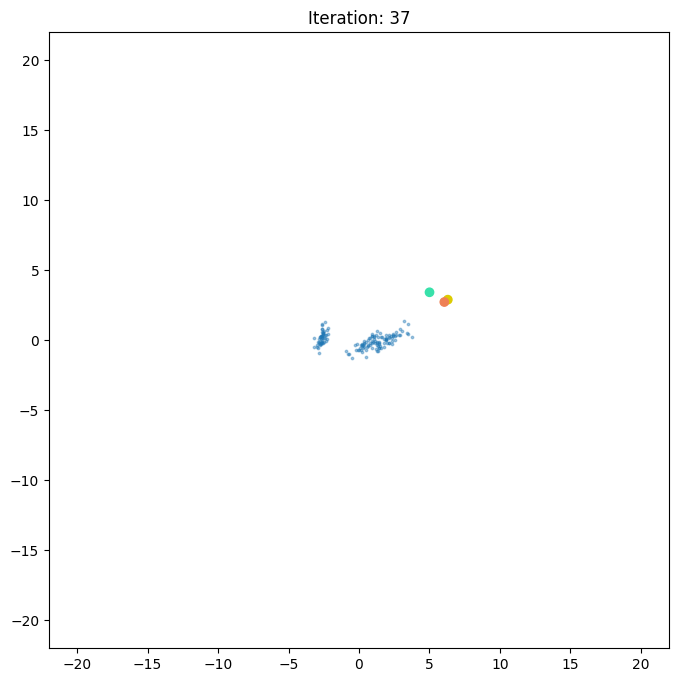

[[[0.42403404 0.09725952 0.43835462 0.15575026]
  [0.09725952 0.10592205 0.11530767 0.07002841]
  [0.43835462 0.11530767 0.61563739 0.24506808]
  [0.15575026 0.07002841 0.24506808 0.16277344]]

 [[0.43893743 0.2022392  0.31048698 0.10734757]
  [0.2022392  0.10424839 0.13769983 0.05127501]
  [0.31048698 0.13769983 0.23333805 0.07783035]
  [0.10734757 0.05127501 0.07783035 0.02922392]]

 [[0.12176396 0.09723186 0.01602798 0.01012401]
  [0.09723186 0.14081567 0.01146395 0.00911202]
  [0.01602798 0.01146395 0.029556   0.005948  ]
  [0.01012401 0.00911202 0.005948   0.010884  ]]]
Iteration: 38, log-likelihood: -185.5730
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

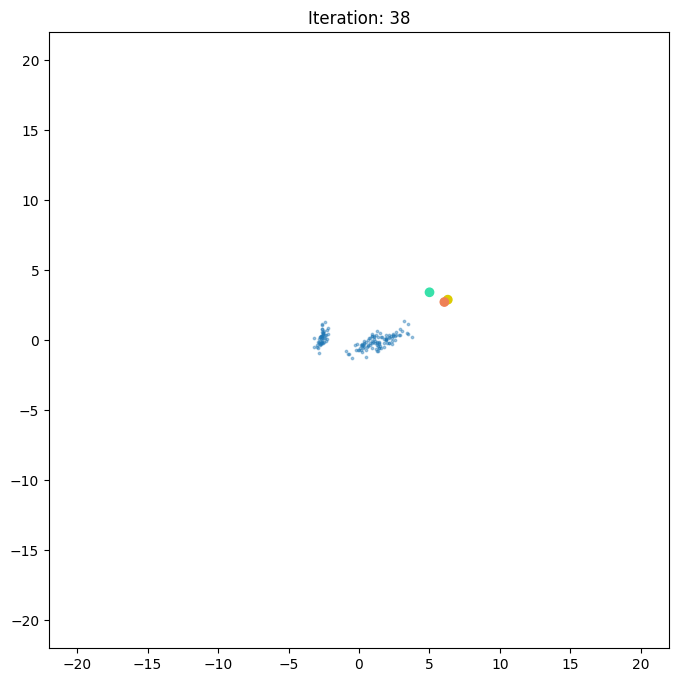

[[[0.42371811 0.09731802 0.43889206 0.15613263]
  [0.09731802 0.10583716 0.1157459  0.07021436]
  [0.43889206 0.1157459  0.61828043 0.24647036]
  [0.15613263 0.07021436 0.24647036 0.16337896]]

 [[0.44220858 0.20374108 0.3117636  0.10764398]
  [0.20374108 0.1050552  0.13827404 0.05145004]
  [0.3117636  0.13827404 0.23248523 0.0772865 ]
  [0.10764398 0.05145004 0.0772865  0.02895708]]

 [[0.12176396 0.09723184 0.01602798 0.01012401]
  [0.09723184 0.14081563 0.01146394 0.00911202]
  [0.01602798 0.01146394 0.029556   0.005948  ]
  [0.01012401 0.00911202 0.005948   0.010884  ]]]
Iteration: 39, log-likelihood: -185.4239
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

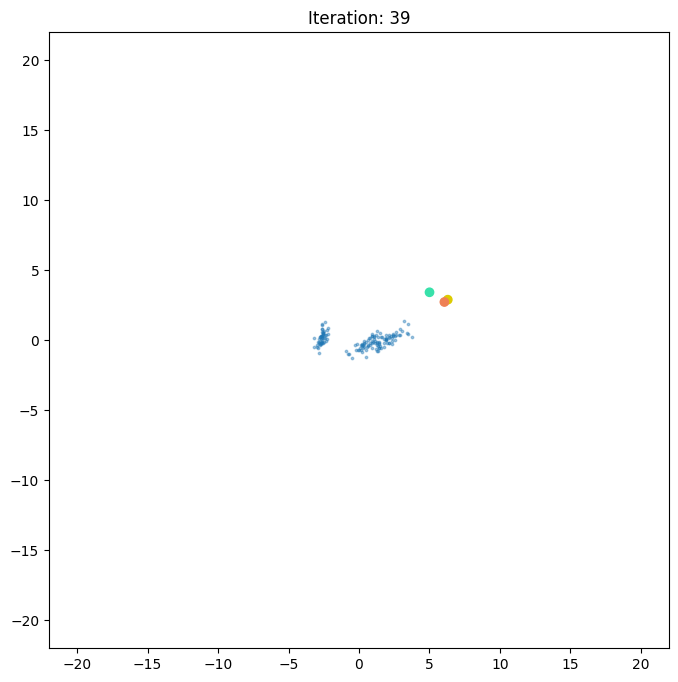

[[[0.42328389 0.09730009 0.43909082 0.15634551]
  [0.09730009 0.1057345  0.1159928  0.07031383]
  [0.43909082 0.1159928  0.62014368 0.2474895 ]
  [0.15634551 0.07031383 0.2474895  0.1638188 ]]

 [[0.44543018 0.20506299 0.313147   0.10791584]
  [0.20506299 0.10573999 0.13875754 0.05156974]
  [0.313147   0.13875754 0.23198815 0.07683339]
  [0.10791584 0.05156974 0.07683339 0.02870655]]

 [[0.12176395 0.09723182 0.01602798 0.01012401]
  [0.09723182 0.14081557 0.01146393 0.00911203]
  [0.01602798 0.01146393 0.029556   0.00594801]
  [0.01012401 0.00911203 0.00594801 0.010884  ]]]
Iteration: 40, log-likelihood: -185.3143
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

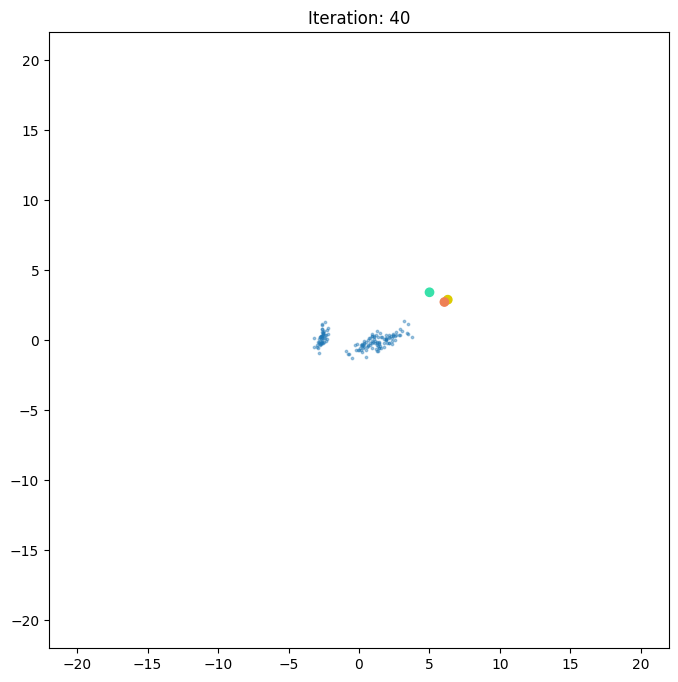

[[[0.4228502  0.09721477 0.43885975 0.15631365]
  [0.09721477 0.10564123 0.11596459 0.07029039]
  [0.43885975 0.11596459 0.62063258 0.24781151]
  [0.15631365 0.07029039 0.24781151 0.16395641]]

 [[0.44761246 0.20577326 0.31421992 0.10806427]
  [0.20577326 0.10607318 0.13897346 0.05157787]
  [0.31421992 0.13897346 0.23204427 0.07660912]
  [0.10806427 0.05157787 0.07660912 0.02854114]]

 [[0.12176394 0.0972318  0.01602797 0.01012402]
  [0.0972318  0.14081552 0.01146393 0.00911203]
  [0.01602797 0.01146393 0.029556   0.00594801]
  [0.01012402 0.00911203 0.00594801 0.010884  ]]]
Iteration: 41, log-likelihood: -185.2830
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

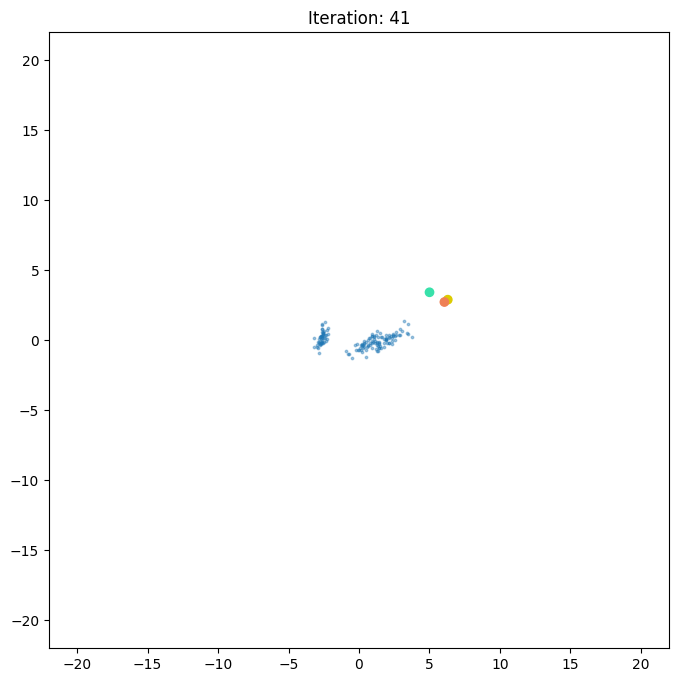

[[[0.42254191 0.09713251 0.43855062 0.15620857]
  [0.09713251 0.10557827 0.11584991 0.07023111]
  [0.43855062 0.11584991 0.62051803 0.24780626]
  [0.15620857 0.07023111 0.24780626 0.16395342]]

 [[0.44879967 0.20604982 0.31487284 0.1081258 ]
  [0.20604982 0.10617973 0.13902176 0.05154074]
  [0.31487284 0.13902176 0.23227972 0.07653236]
  [0.1081258  0.05154074 0.07653236 0.02845582]]

 [[0.12176394 0.09723179 0.01602797 0.01012402]
  [0.09723179 0.1408155  0.01146392 0.00911203]
  [0.01602797 0.01146392 0.029556   0.00594801]
  [0.01012402 0.00911203 0.00594801 0.010884  ]]]
Iteration: 42, log-likelihood: -185.2776
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

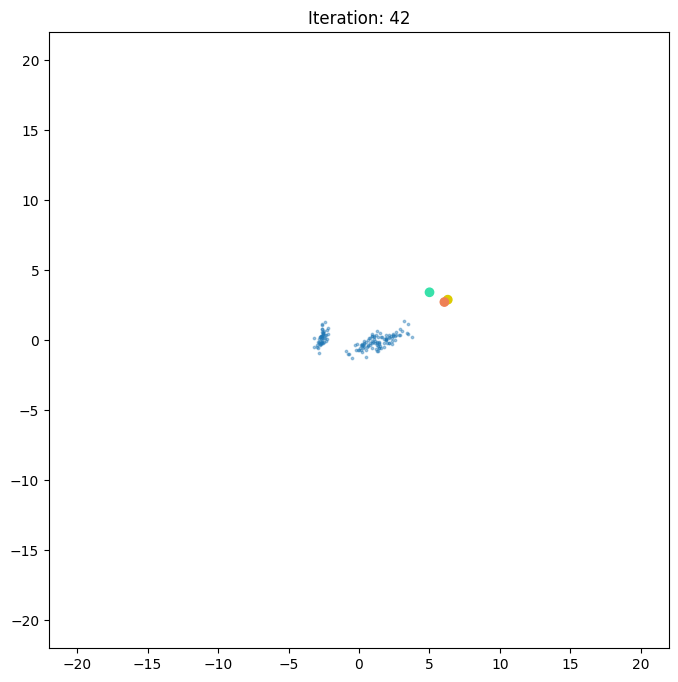

[[[0.42236558 0.09707836 0.4383526  0.15613489]
  [0.09707836 0.1055421  0.11576368 0.07018794]
  [0.4383526  0.11576368 0.62037015 0.24775784]
  [0.15613489 0.07018794 0.24775784 0.16393203]]

 [[0.44942065 0.20616702 0.31524321 0.10816384]
  [0.20616702 0.10621878 0.13903604 0.05151652]
  [0.31524321 0.13903604 0.23247051 0.07651619]
  [0.10816384 0.05151652 0.07651619 0.0284199 ]]

 [[0.12176394 0.09723179 0.01602797 0.01012402]
  [0.09723179 0.14081549 0.01146392 0.00911203]
  [0.01602797 0.01146392 0.029556   0.00594801]
  [0.01012402 0.00911203 0.00594801 0.010884  ]]]
Iteration: 43, log-likelihood: -185.2765
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

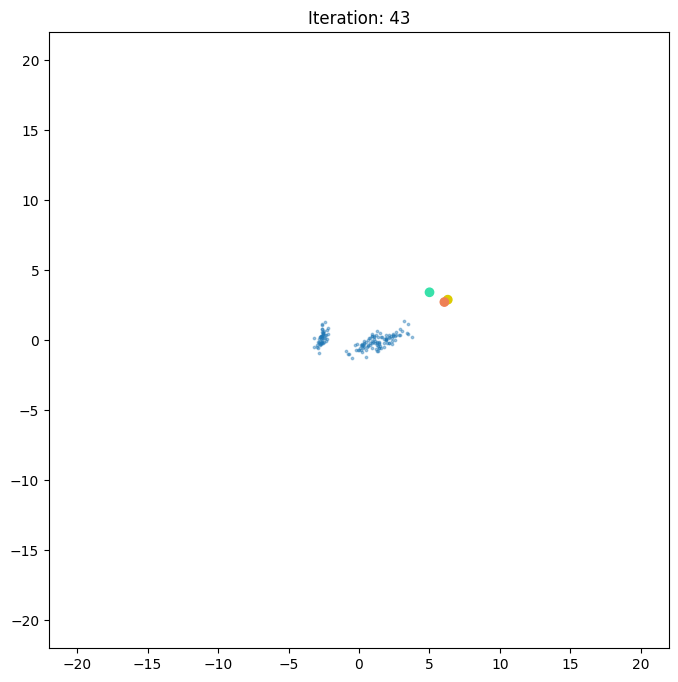

[[[0.42227433 0.09704758 0.43824963 0.15609564]
  [0.09704758 0.10552301 0.1157141  0.07016345]
  [0.43824963 0.1157141  0.6202811  0.2477239 ]
  [0.15609564 0.07016345 0.2477239  0.16391695]]

 [[0.44973846 0.20622191 0.31544459 0.10818892]
  [0.20622191 0.10623667 0.13904445 0.05150569]
  [0.31544459 0.13904445 0.23258987 0.07651781]
  [0.10818892 0.05150569 0.07651781 0.02840609]]

 [[0.12176394 0.09723179 0.01602797 0.01012402]
  [0.09723179 0.14081549 0.01146392 0.00911203]
  [0.01602797 0.01146392 0.029556   0.00594801]
  [0.01012402 0.00911203 0.00594801 0.010884  ]]]
Iteration: 44, log-likelihood: -185.2763
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

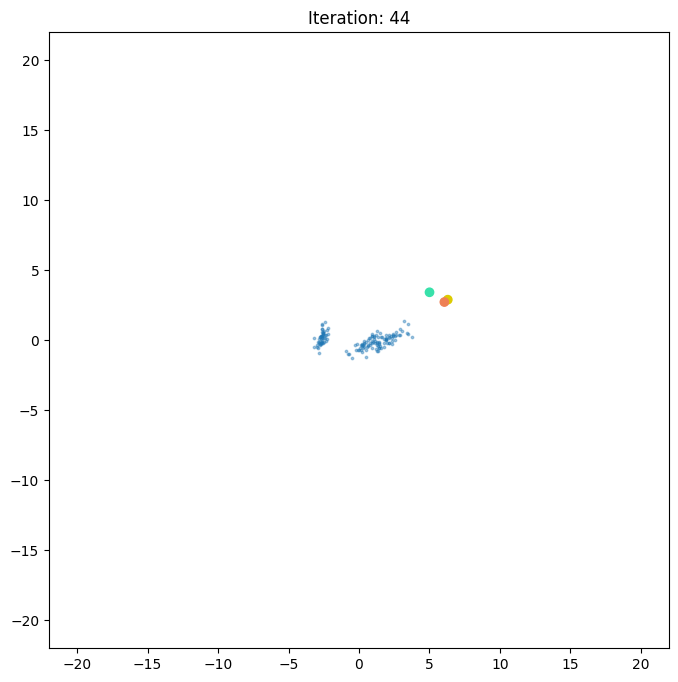

[[[0.42222913 0.09703135 0.43819971 0.15607654]
  [0.09703135 0.10551345 0.11568815 0.07015075]
  [0.43819971 0.11568815 0.62023497 0.24770494]
  [0.15607654 0.07015075 0.24770494 0.16390847]]

 [[0.4498979  0.20624784 0.31555039 0.10820382]
  [0.20624784 0.10624514 0.13904951 0.05150112]
  [0.31555039 0.13904951 0.23265756 0.07652221]
  [0.10820382 0.05150112 0.07652221 0.02840084]]

 [[0.12176394 0.09723179 0.01602797 0.01012402]
  [0.09723179 0.14081549 0.01146392 0.00911203]
  [0.01602797 0.01146392 0.029556   0.00594801]
  [0.01012402 0.00911203 0.00594801 0.010884  ]]]
Iteration: 45, log-likelihood: -185.2762
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

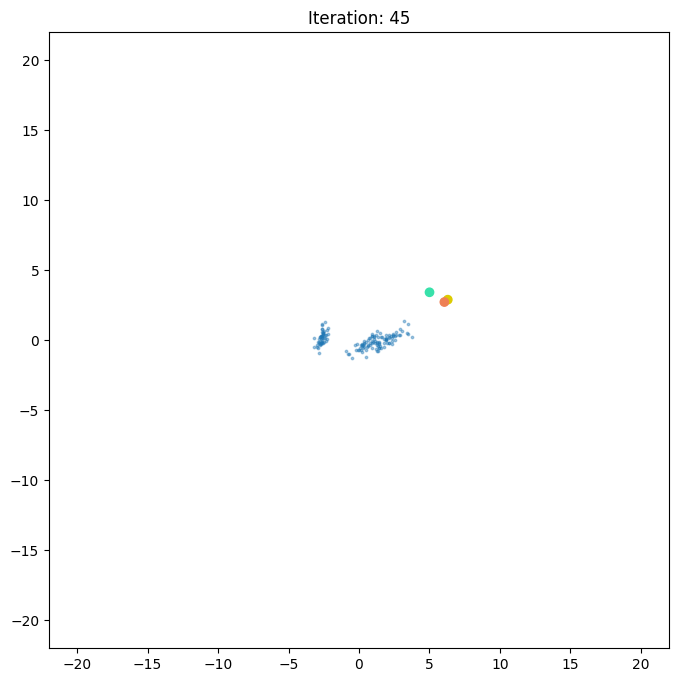

[[[0.42220709 0.09702312 0.43817606 0.15606755]
  [0.09702312 0.1055088  0.11567509 0.07014441]
  [0.43817606 0.11567509 0.62021219 0.24769508]
  [0.15606755 0.07014441 0.24769508 0.16390404]]

 [[0.4499771  0.20625997 0.31560488 0.10821209]
  [0.20625997 0.10624904 0.13905231 0.05149914]
  [0.31560488 0.13905231 0.23269423 0.07652571]
  [0.10821209 0.05149914 0.07652571 0.02839884]]

 [[0.12176394 0.09723179 0.01602797 0.01012402]
  [0.09723179 0.14081549 0.01146392 0.00911203]
  [0.01602797 0.01146392 0.029556   0.00594801]
  [0.01012402 0.00911203 0.00594801 0.010884  ]]]
Iteration: 46, log-likelihood: -185.2762
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

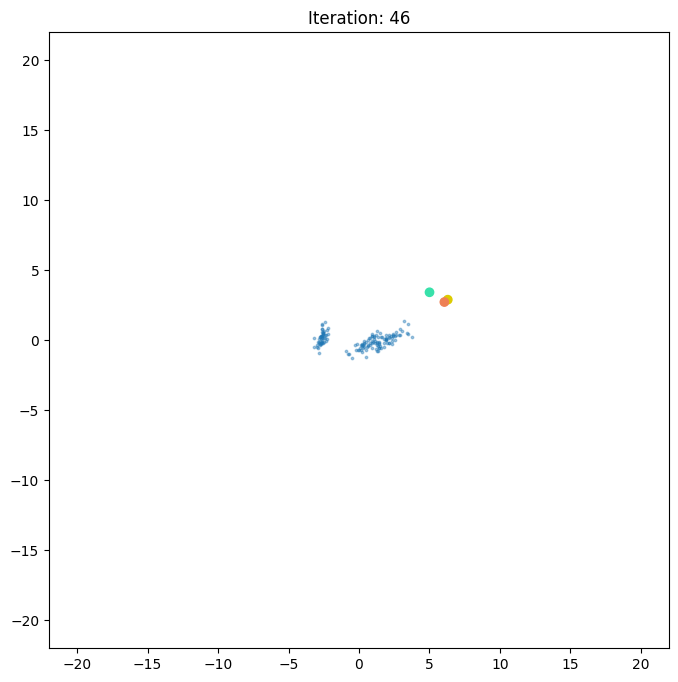

[[[0.4221964  0.09701902 0.43816491 0.15606335]
  [0.09701902 0.10550656 0.11566862 0.07014129]
  [0.43816491 0.11566862 0.6202011  0.2476901 ]
  [0.15606335 0.07014129 0.2476901  0.1639018 ]]

 [[0.45001629 0.20626561 0.31563263 0.10821651]
  [0.20626561 0.10625079 0.13905376 0.05149827]
  [0.31563263 0.13905376 0.23271361 0.07652795]
  [0.10821651 0.05149827 0.07652795 0.02839807]]

 [[0.12176394 0.09723179 0.01602797 0.01012402]
  [0.09723179 0.14081549 0.01146392 0.00911203]
  [0.01602797 0.01146392 0.029556   0.00594801]
  [0.01012402 0.00911203 0.00594801 0.010884  ]]]
Iteration: 47, log-likelihood: -185.2762
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

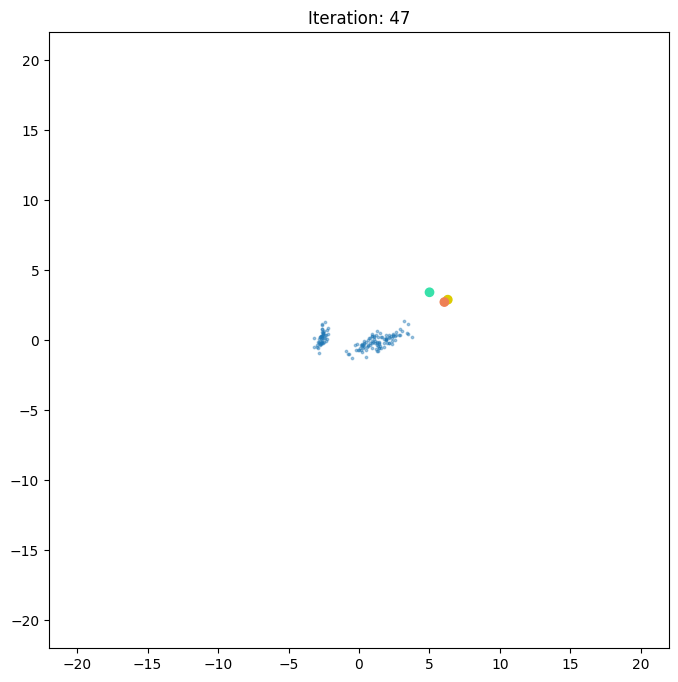

[[[0.42219121 0.097017   0.43815964 0.15606139]
  [0.097017   0.10550549 0.11566544 0.07013976]
  [0.43815964 0.11566544 0.62019573 0.24768762]
  [0.15606139 0.07013976 0.24768762 0.16390067]]

 [[0.45003567 0.20626823 0.31564669 0.10821882]
  [0.20626823 0.10625157 0.1390545  0.05149786]
  [0.31564669 0.1390545  0.23272368 0.07652925]
  [0.10821882 0.05149786 0.07652925 0.02839778]]

 [[0.12176394 0.09723179 0.01602797 0.01012402]
  [0.09723179 0.14081549 0.01146392 0.00911203]
  [0.01602797 0.01146392 0.029556   0.00594801]
  [0.01012402 0.00911203 0.00594801 0.010884  ]]]
Iteration: 48, log-likelihood: -185.2762
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

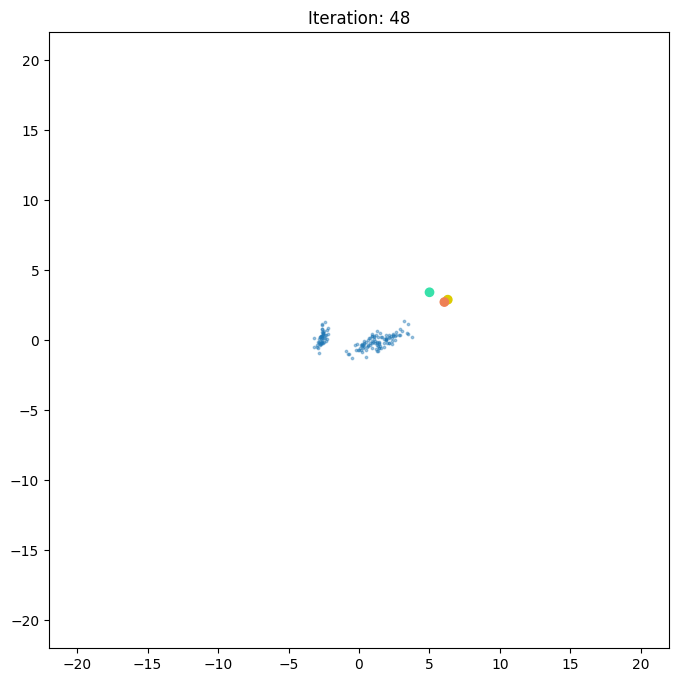

[[[0.42218868 0.097016   0.43815713 0.15606046]
  [0.097016   0.10550498 0.11566387 0.07013902]
  [0.43815713 0.11566387 0.62019311 0.24768638]
  [0.15606046 0.07013902 0.24768638 0.16390011]]

 [[0.45004526 0.20626945 0.31565377 0.10822001]
  [0.20626945 0.10625191 0.13905486 0.05149768]
  [0.31565377 0.13905486 0.23272887 0.07652998]
  [0.10822001 0.05149768 0.07652998 0.02839767]]

 [[0.12176394 0.09723179 0.01602797 0.01012402]
  [0.09723179 0.14081549 0.01146392 0.00911203]
  [0.01602797 0.01146392 0.029556   0.00594801]
  [0.01012402 0.00911203 0.00594801 0.010884  ]]]
Iteration: 49, log-likelihood: -185.2762
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

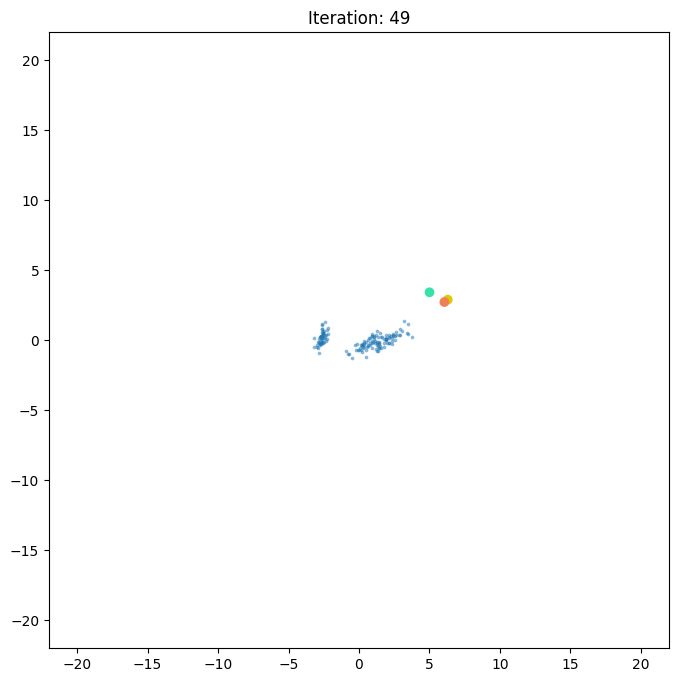

[[[0.42218744 0.0970155  0.43815593 0.15606003]
  [0.0970155  0.10550473 0.1156631  0.07013865]
  [0.43815593 0.1156631  0.62019184 0.24768576]
  [0.15606003 0.07013865 0.24768576 0.16389983]]

 [[0.45005001 0.20627002 0.31565733 0.10822062]
  [0.20627002 0.10625206 0.13905505 0.05149759]
  [0.31565733 0.13905505 0.23273152 0.07653036]
  [0.10822062 0.05149759 0.07653036 0.02839763]]

 [[0.12176394 0.09723179 0.01602797 0.01012402]
  [0.09723179 0.14081549 0.01146392 0.00911203]
  [0.01602797 0.01146392 0.029556   0.00594801]
  [0.01012402 0.00911203 0.00594801 0.010884  ]]]
Iteration: 50, log-likelihood: -185.2762
Drawing available only for 2D case.


<Figure size 640x480 with 0 Axes>

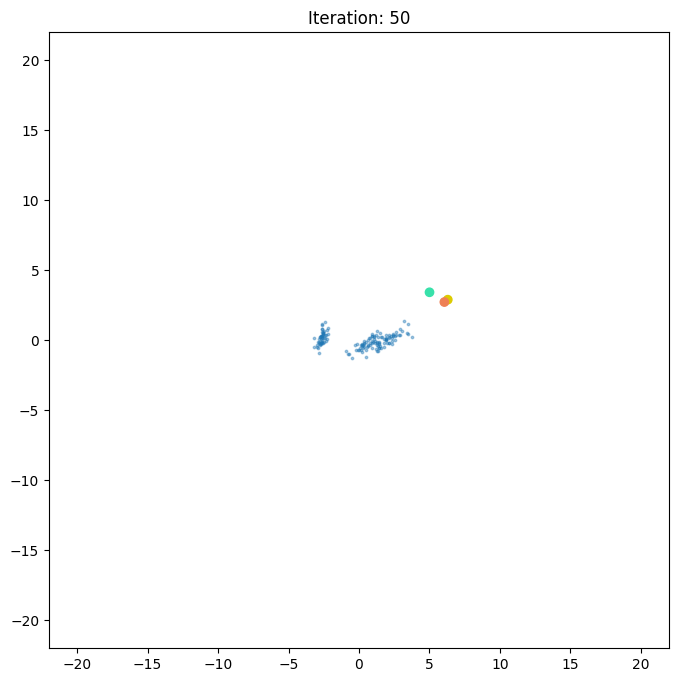

<Figure size 640x480 with 0 Axes>

In [9]:
# Training the GMM using EM

# Initialize EM algo with data
gmm.init_em(X)

num_iters = 50
# Saving log-likelihood
log_likelihood = [gmm.log_likelihood(X)]
# plotting
plot("Iteration:  0")
for e in range(num_iters):
    # E-step
    gmm.e_step()
    # M-step
    gmm.m_step()
    # Computing log-likelihood
    log_likelihood.append(gmm.log_likelihood(X))
    print("Iteration: {}, log-likelihood: {:.4f}".format(e+1, log_likelihood[-1]))
    # plotting
    plot(title="Iteration: " + str(e+1))

In [11]:
labels = np.argmax(gmm.z, axis=1)
labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [12]:
def count_max_freq(array):
  values = list(set(array))
  freq = [0] * len(values)
  for a in array:
    index = values.index(a)
    freq[index] += 1
  return max(freq)

In [13]:
for i in range(3):
  pred = labels[50 * i : 50 * (i + 1)]
  print("Tỷ lệ số điểm được phân cùng một cụm ở cụm thứ", i,":", count_max_freq(pred) / 50 * 100, "%")

Tỷ lệ số điểm được phân cùng một cụm ở cụm thứ 0 : 100.0 %
Tỷ lệ số điểm được phân cùng một cụm ở cụm thứ 1 : 64.0 %
Tỷ lệ số điểm được phân cùng một cụm ở cụm thứ 2 : 100.0 %


BAI TU THUC HANH 2

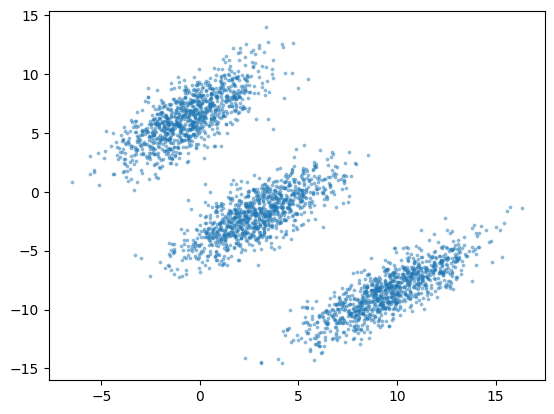

In [14]:
# Generate random 2D data with 3 clusters 
X = gen_data(k=3, dim=2, points_per_cluster=1000)

In [15]:
def kmeans_display(X, label): 
    K = np.amax(label) + 1 
    X0 = X[label == 0, :] 
    X1 = X[label == 1, :] 
    X2 = X[label == 2, :] 
     
    plt.plot(X0[:, 0], X0[:, 1], 'b^', markersize = 4, alpha = .8) 
    plt.plot(X1[:, 0], X1[:, 1], 'go', markersize = 4, alpha = .8) 
    plt.plot(X2[:, 0], X2[:, 1], 'rs', markersize = 4, alpha = .8) 
 
    plt.axis('equal') 
    plt.plot()
    plt.show()

Centers found by scikit-learn:
[[-0.54968985  6.38782077]
 [ 9.58715457 -8.41964751]
 [ 2.87117777 -1.90909654]]


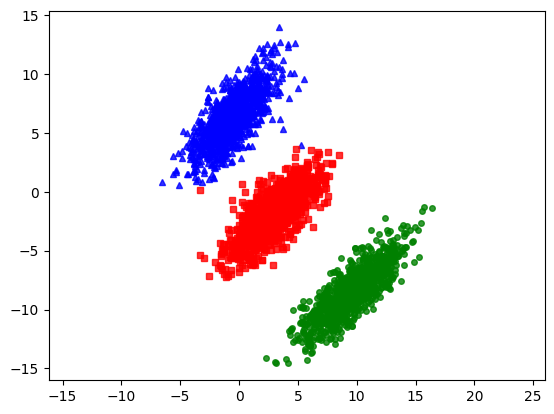

In [16]:
from sklearn.cluster import KMeans 
kmeans = KMeans(n_clusters=3, random_state=0).fit(X) 
print('Centers found by scikit-learn:') 
print(kmeans.cluster_centers_) 
pred_label = kmeans.predict(X) 
kmeans_display(X, pred_label) 

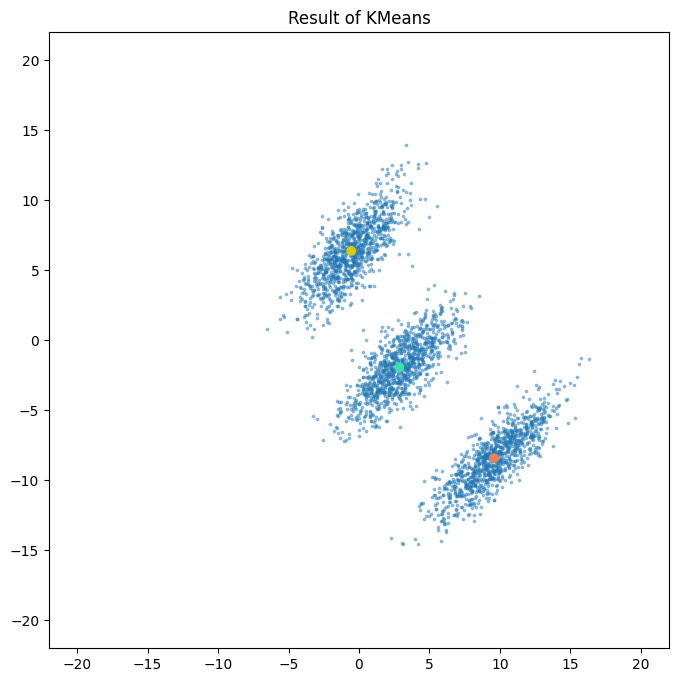

<Figure size 640x480 with 0 Axes>

In [17]:
def plot3(title):
    '''
    Draw the data points and the fitted mixture model.
    input:
        - title: title of plot and name with which it will be saved.
    '''
    centers = kmeans.cluster_centers_
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    ax.scatter(X[:, 0], X[:, 1], s=3, alpha=0.4)
    ax.scatter(centers[:, 0], centers[:, 1], c=gmm.colors)
    ax.set_xlim((-22, 22))
    ax.set_ylim((-22, 22))

    plt.title(title)
    # plt.savefig(title.replace(':', '_'))
    plt.show()
    plt.clf()
plot3("Result of KMeans")